In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [4]:
from solver import deasolver

In [5]:
results = []
df_imp = pd.DataFrame()

In [6]:
df = pd.read_excel("Data/US12I1O.xlsx", index_col = 0)
df

Input 01  Input 02  Input 03  Input 04  Input 05  Input 06  \
DMU 0001    288.81    493.46    202.31    356.18    384.45    653.77   
DMU 0002    349.98    420.00    139.32    312.89    543.04    504.54   
DMU 0003    280.78    452.42    127.85    315.42    559.22    466.35   
DMU 0004    405.33    376.32    237.28    451.43    414.19    318.03   
DMU 0005    348.96    426.79    170.01    292.91    502.76    342.94   
...            ...       ...       ...       ...       ...       ...   
DMU 0996    206.54    333.40    274.01    424.09    465.99    548.04   
DMU 0997    328.82    415.09    121.60    268.46    494.32    454.22   
DMU 0998    310.52    565.44    126.06    320.91    463.01    390.07   
DMU 0999    390.34    255.88    209.15    269.76    576.57    261.14   
DMU 1000    251.60    497.67    256.31    477.68    338.44    716.68   

          Input 07  Input 08  Input 09  Input 10  Input 11  Input 12  \
DMU 0001    129.40    100.28     38.45    306.59     92.41    250.91   
DMU 0002    120.43    177.65     86.96    330.87     79.16    201.81   
DMU 0003    166.57    165.57     81.43    359.75     83.23    246.78   
DMU 0004    187.77    154.65     49.71    316.82     97.74    344.70   
DMU 0005    146.53    165.78     63.80    329.79     76.17    355.61   
...            ...       ...       ...       ...       ...       ...   
DMU 0996    143.02     58.25     49.65    355.16     85.54    238.49   
DMU 0997    150.96    143.44     65.04    374.88     69.81    261.57   
DMU 0998    151.81    202.55    101.67    333.12     87.52    328.13   
DMU 0999    162.39    102.92     66.70    401.16     72.50    318.26   
DMU 1000    158.12    157.51     37.08    273.94     91.51    296.31   

          Output 01  
DMU 0001     250.77  
DMU 0002     372.71  
DMU 0003     293.40  
DMU 0004     462.69  
DMU 0005     374.18  
...             ...  
DMU 0996     279.23  
DMU 0997     344.45  
DMU 0998     320.62  
DMU 0999     380.24  
DMU 1000     408.37  

[1000 rows x 13 columns]

In [7]:
def ml(df=df, sol_filepath="Data/Data12/US12I1O_Sol_0.xlsx", i=None):
    
    df_sol = pd.read_excel(sol_filepath, index_col = 0)[['Efficiency_Scores']]
    df_weights = pd.read_excel(sol_filepath, index_col = 0).iloc[:, 1:]
    
    df_zero = (df_weights==0).sum()
    print("df_zero: \n", df_zero)
    
    total_zeros = (df_weights==0).sum().sum()
    print("Total Zeros: ", total_zeros)
    
    plt.figure(figsize=(18,12))
    sns.heatmap(df_weights.eq(0).transpose(),
            cmap="YlGnBu",
            cbar=False,
            cbar_kws={'label': 'Zero Values'});
    
    X = df
    y = df_sol
    
    std_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()
    
    dt_model = DecisionTreeRegressor(random_state=42)

    pipe_dt = make_pipeline(std_scaler, dt_model)

    # cross-validate the pipeline
    print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
    print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
    print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())
    
    # specify parameter values to search
    params = {}
    params['decisiontreeregressor__max_depth'] = list(range(1, 15))
    params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
    params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]
    
    grid = GridSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
    grid.fit(X, y)
    
    print("grid.best_score: ", grid.best_score_)
    print("grid.best_params: ", grid.best_params_)
    print("grid.best_estimator: ", grid.best_estimator_)
    print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())
    
    imp_dt = grid.best_estimator_.steps[1][1].feature_importances_
    df_dt = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_dt}).sort_values("Importance", ascending=False)
    input_imp = list(df_dt.loc[df_dt["Feature Name"].str.contains("Input"), "Feature Name"].values)
    results = (i,
                grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_,
               "total_zeros": total_zeros},
              )
    
    fig = px.bar(df_dt, x="Importance", y="Feature Name")

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"DecisionTreeRegressor Feature Importances",
        yaxis={'categoryorder':'total ascending'}
    )

    fig.show()
    
    df_zero.index = [f.split('_')[1] for f in df_zero.index]
    
    df_merged = pd.merge(df_dt, df_zero.reset_index(), left_on='Feature Name', right_on='index')
    df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
    
    df_merged["Iteration"] = i
    
    fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"DecisionTreeRegressor Feature Importance - Zero_Count Relationship",
    )

    fig.show()
    
    return pipe_dt, results, y, df_merged

In [8]:
def plotScatter(res_dt, x, y, colorCol, blueCount, redCount):

    fig = px.scatter(res_dt, x=x, y=y, color = colorCol, color_discrete_map= {True:"blue", False: "red"},
                     hover_data=[x, y, colorCol] + [res_dt.index])


    fig.add_traces(
        list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
    )

    fig.update_traces(line_color='lightgreen', line_width=3)

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"Efficiency Scores Comparison (Blue: {blueCount}, Red: {redCount})",
    )

    fig.show()

In [9]:
def compareML(pipe_dt, y, X=df, err_thresh = 3):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = pipe_dt.fit(X_train, y_train)
    prediction = model.predict(X_test)
        
    res = pd.DataFrame()
    res["Prediction"] = pd.Series(prediction.ravel())
    res["Actual"] = y_test.values
    res["Diff"] = res.Prediction - res.Actual
    res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
    res[f"Error_Perc < {err_thresh}"] = np.abs(res["Error_Perc"]) < err_thresh  
    res = res.round(4)
    print("res: ", res)
    
    blue = res[f"Error_Perc < {err_thresh}"].sum()
    print("blue: ", blue)
    red = len(res[f"Error_Perc < {err_thresh}"]) - (res[f"Error_Perc < {err_thresh}"].sum())
    print("red: ", red)
    
    rho, p = stats.spearmanr(res.Prediction, res.Actual)
    print("rho:", rho.round(4)) 
    print("p-Value", p.round(4)) 
    
    plotScatter(res, x="Actual", y="Prediction", colorCol=f"Error_Perc < {err_thresh}",
               blueCount=blue, redCount=red)

In [10]:
def compareES(df_1_path=None, df_0_path=None, df_basic_path="Data/Data12/US12I1O_Sol_0.xlsx", err_thresh = 10):
    
    df_basic = pd.read_excel(df_basic_path, index_col=0)
    df_1 = pd.read_excel(df_1_path, index_col=0)
    
    res_dt = pd.DataFrame()
    res_dt["Efficiency_Scores_Basic"] = df_basic["Efficiency_Scores"]
    res_dt["Efficiency_Scores_ML"] = df_1["Efficiency_Scores"]

    
    res_dt["Diff_Basic"] = res_dt["Efficiency_Scores_Basic"]  - res_dt["Efficiency_Scores_ML"]
    res_dt["Diff_Basic_Perc"] = (res_dt["Diff_Basic"] / res_dt["Efficiency_Scores_Basic"]) * 100 
    res_dt[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_dt["Diff_Basic_Perc"]) < err_thresh
    
    res_dt["Diff_Basic"] = res_dt["Efficiency_Scores_Basic"]  - res_dt["Efficiency_Scores_ML"]
    res_dt["Diff_Basic_Perc"] = (res_dt["Diff_Basic"] / res_dt["Efficiency_Scores_Basic"]) * 100 
    res_dt[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_dt["Diff_Basic_Perc"]) < err_thresh
    
    blue = res_dt[f"Diff_Basic_Perc < {err_thresh}"].sum()
    print("blue : ", blue)
    red = len(res_dt[f"Diff_Basic_Perc < {err_thresh}"]) - (res_dt[f"Diff_Basic_Perc < {err_thresh}"].sum())
    print("red : ", red)
    
    res_dt = res_dt.round(4)
    
    plotScatter(res_dt, x="Efficiency_Scores_Basic", y="Efficiency_Scores_ML", colorCol=f"Diff_Basic_Perc < {err_thresh}",
               blueCount=blue, redCount=red)
       
    if df_0_path:
        
        df_0 = pd.read_excel(df_0_path, index_col=0)
        res_dt["Efficiency_Scores_ML_Pr"] = df_0["Efficiency_Scores"]
        
        res_dt["Diff_Previous"] = res_dt["Efficiency_Scores_ML_Pr"]  - res_dt["Efficiency_Scores_ML"]
        res_dt["Diff_Previous_Perc"] = (res_dt["Diff_Previous"] / res_dt["Efficiency_Scores_ML_Pr"]) * 100 
        res_dt[f"Diff_Previous_Perc < {err_thresh}"] = np.abs(res_dt["Diff_Previous_Perc"]) < err_thresh
        
        blue = res_dt[f"Diff_Previous_Perc < {err_thresh}"].sum()
        print("blue : ", blue)
        red = len(res_dt[f"Diff_Previous_Perc < {err_thresh}"]) - (res_dt[f"Diff_Previous_Perc < {err_thresh}"].sum())
        print("red : ", red)
        
        #res_dt = res_dt.round(4)
        
        plotScatter(res_dt, x="Efficiency_Scores_ML_Pr", y="Efficiency_Scores_ML", colorCol=f"Diff_Previous_Perc < {err_thresh}",
               blueCount=blue, redCount=red)


### i=0

In [11]:
i=0

In [12]:
#deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_" + str(i))

df_zero: 
 Weight_Input 01     330
Weight_Input 02     801
Weight_Input 03     249
Weight_Input 04     717
Weight_Input 05     681
Weight_Input 06     396
Weight_Input 07     673
Weight_Input 08     428
Weight_Input 09     599
Weight_Input 10     830
Weight_Input 11     742
Weight_Input 12     757
Weight_Output 01      0
dtype: int64
Total Zeros:  7203
neg_mean_squared_error: -0.005124038357440072
neg_root_mean_squared_error: -0.07154992425394101
r2: 0.6792044677931406
grid.best_score:  -0.06419162390336428
grid.best_params:  {'decisiontreeregressor__max_depth': 13, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 40}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=13, max_features='auto',
                                       min_samples_split=40,
                                       random_state=42))])
grid.r2:  0.73966617

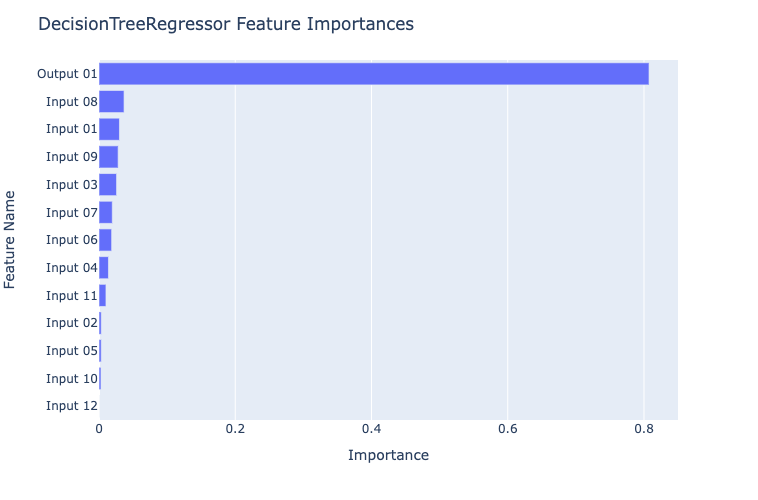

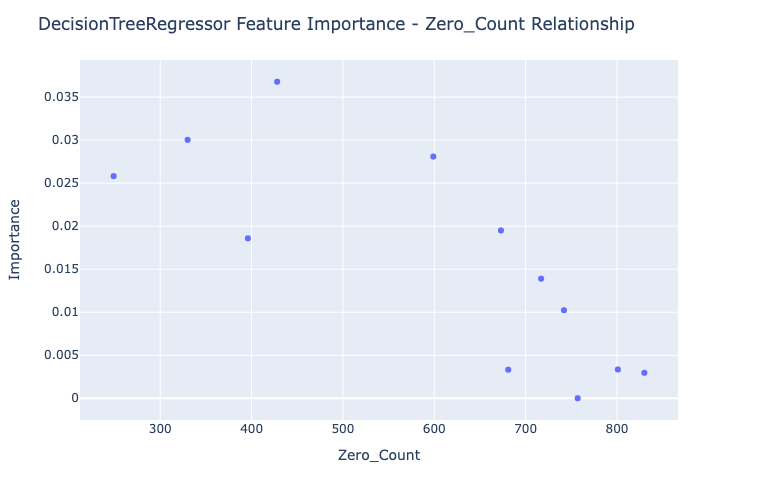

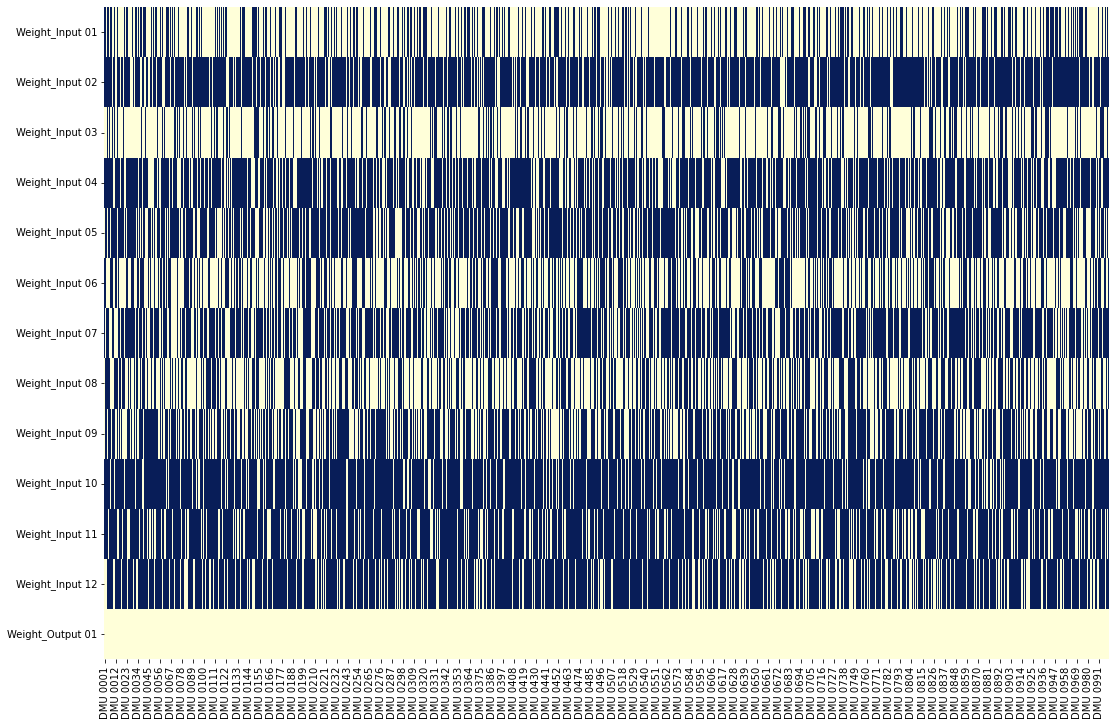

In [13]:
pipe_dt, r, y, df_merged = ml(i=i)
results.append(r)

In [14]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.807431  Output 01           0          0
1      Input 08    0.036786   Input 08         428          0
2      Input 01    0.030032   Input 01         330          0
3      Input 09    0.028091   Input 09         599          0
4      Input 03    0.025816   Input 03         249          0
5      Input 07    0.019504   Input 07         673          0
6      Input 06    0.018587   Input 06         396          0
7      Input 04    0.013899   Input 04         717          0
8      Input 11    0.010232   Input 11         742          0
9      Input 02    0.003346   Input 02         801          0
10     Input 05    0.003320   Input 05         681          0
11     Input 10    0.002958   Input 10         830          0
12     Input 12    0.000000   Input 12         757          0

In [15]:
results

[(0,
  'decisiontreeregressor',
  ['Input 08',
   'Input 01',
   'Input 09',
   'Input 03',
   'Input 07',
   'Input 06',
   'Input 04',
   'Input 11',
   'Input 02',
   'Input 05',
   'Input 10',
   'Input 12'],
  {'r2': 0.7396661719274343,
   'neg_root_mean_squared_error': -0.06419162390336428,
   'total_zeros': 7203})]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7511  0.7514 -0.0003     -0.0443            True
1        0.8579  0.8656 -0.0078     -0.8954            True
2        0.9351  1.0000 -0.0649     -6.4898           False
3        0.8743  0.8711  0.0033      0.3741            True
4        0.7200  0.7903 -0.0703     -8.9002           False
..          ...     ...     ...         ...             ...
195      0.7550  0.7837 -0.0287     -3.6608           False
196      0.9563  0.8507  0.1056     12.4106           False
197      0.7894  0.8364 -0.0470     -5.6191           False
198      1.0000  1.0000  0.0000      0.0000            True
199      0.8445  0.8264  0.0181      2.1959            True

[200 rows x 5 columns]
blue:  57
red:  143
rho: 0.8253
p-Value 0.0


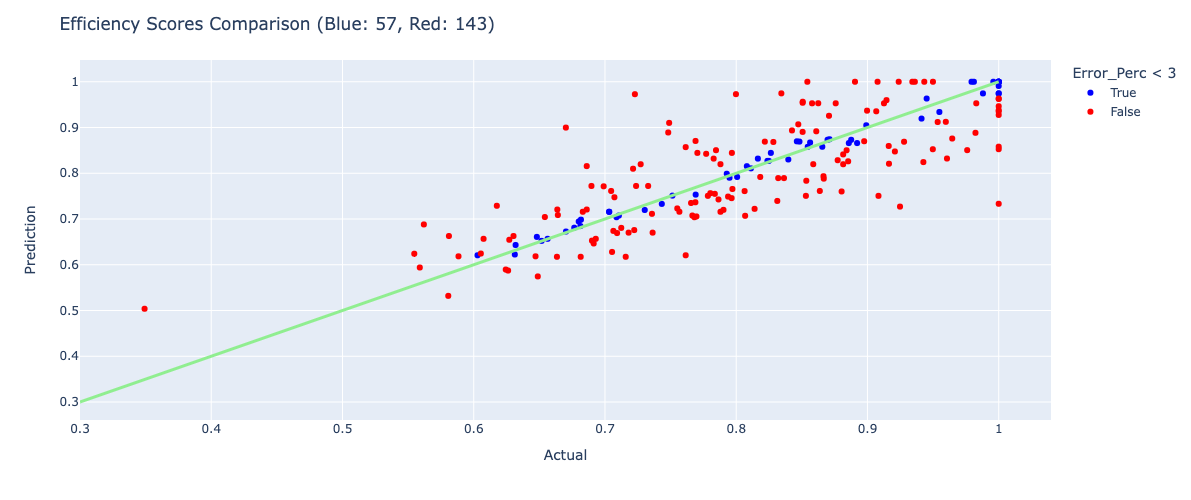

In [16]:
compareML(pipe_dt, y)

In [17]:
results

[(0,
  'decisiontreeregressor',
  ['Input 08',
   'Input 01',
   'Input 09',
   'Input 03',
   'Input 07',
   'Input 06',
   'Input 04',
   'Input 11',
   'Input 02',
   'Input 05',
   'Input 10',
   'Input 12'],
  {'r2': 0.7396661719274343,
   'neg_root_mean_squared_error': -0.06419162390336428,
   'total_zeros': 7203})]

### i = 1

In [18]:
i +=1
i

1

In [19]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       1
Weight_Input 02     662
Weight_Input 03       6
Weight_Input 04     368
Weight_Input 05     772
Weight_Input 06     102
Weight_Input 07      73
Weight_Input 08       0
Weight_Input 09       4
Weight_Input 10     810
Weight_Input 11     494
Weight_Input 12     862
Weight_Output 01      0
dtype: int64
Total Zeros:  4154
neg_mean_squared_error: -0.0028971994420115303
neg_root_mean_squared_error: -0.0537827810839694
r2: 0.7687708689236779
grid.best_score:  -0.04942233539912765
grid.best_params:  {'decisiontreeregressor__max_depth': 8, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 50}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=8, max_features='auto',
                                       min_samples_split=50,
                                       random_state=42))])
grid.r2:  0.8032068179

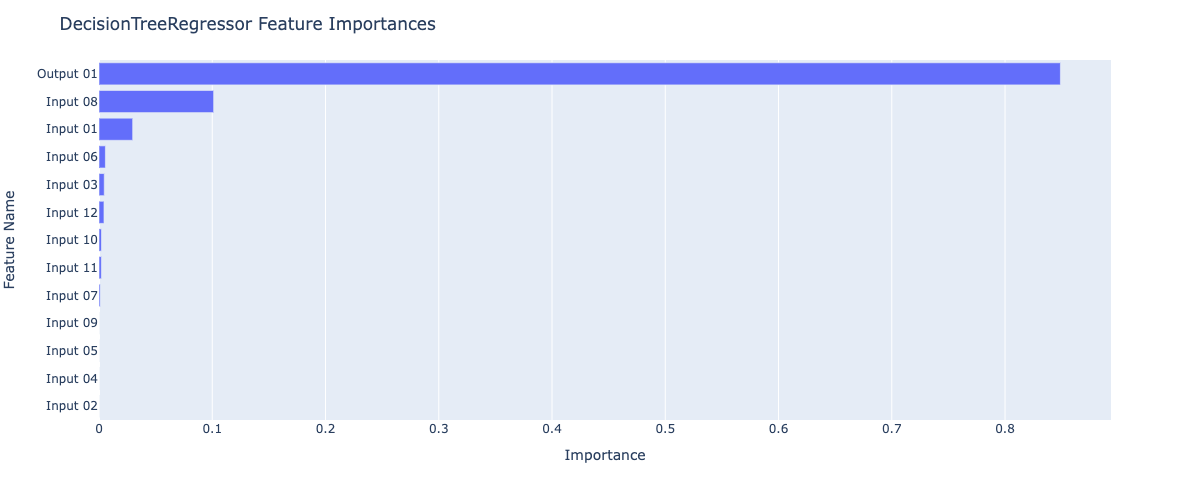

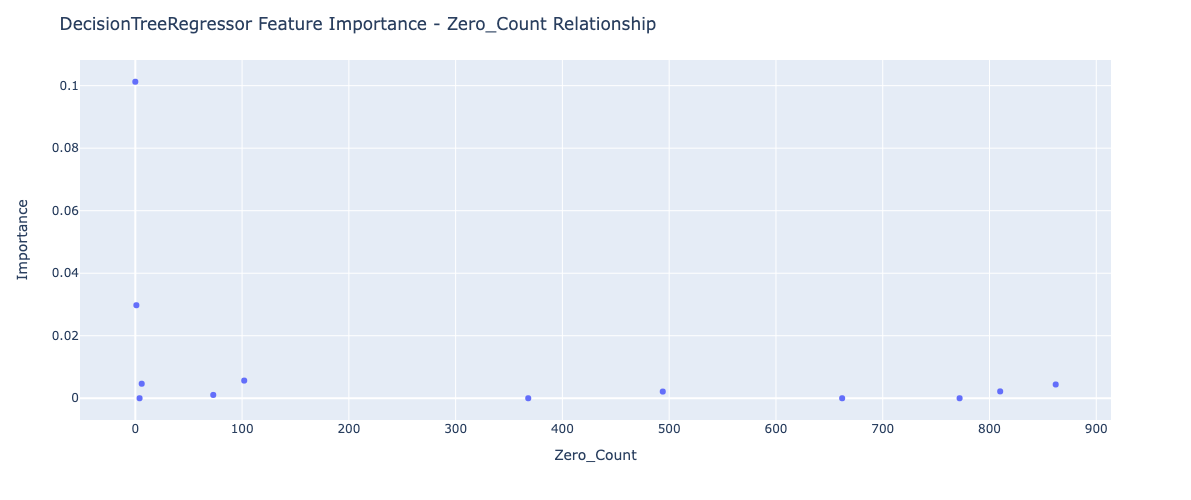

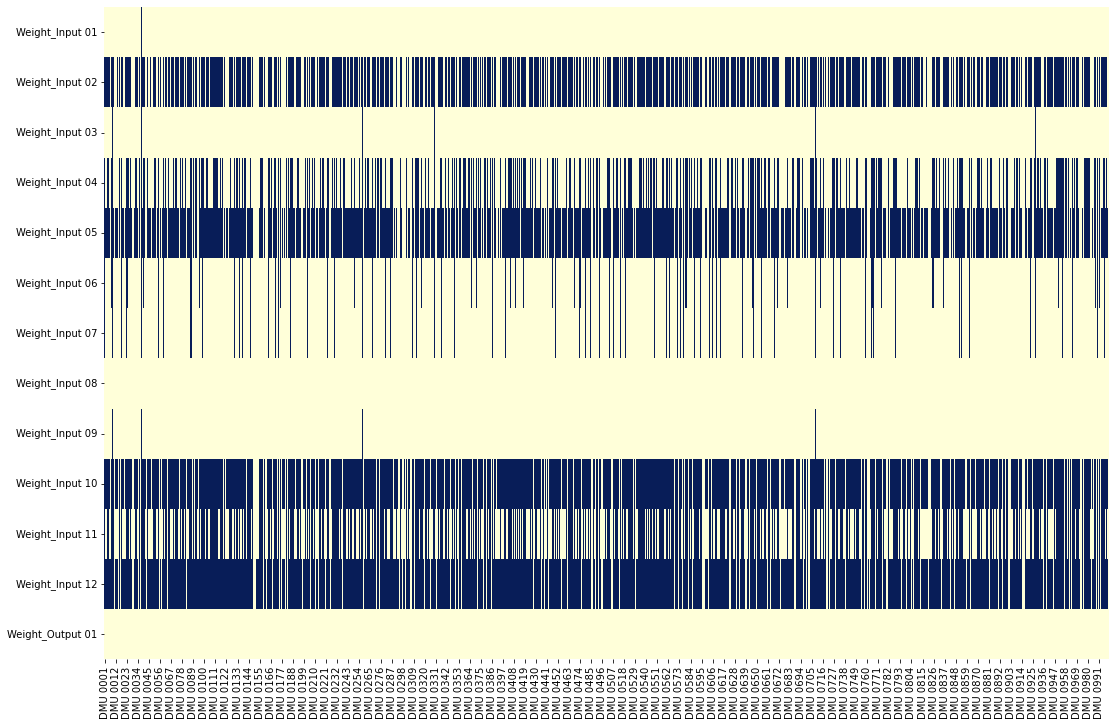

In [20]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_1.xlsx", i=i)
results.append(r)

In [21]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.807431  Output 01           0          0
1      Input 08    0.036786   Input 08         428          0
2      Input 01    0.030032   Input 01         330          0
3      Input 09    0.028091   Input 09         599          0
4      Input 03    0.025816   Input 03         249          0
5      Input 07    0.019504   Input 07         673          0
6      Input 06    0.018587   Input 06         396          0
7      Input 04    0.013899   Input 04         717          0
8      Input 11    0.010232   Input 11         742          0
9      Input 02    0.003346   Input 02         801          0
10     Input 05    0.003320   Input 05         681          0
11     Input 10    0.002958   Input 10         830          0
12     Input 12    0.000000   Input 12         757          0
13    Output 01    0.848902  Output 01           0          1
14     Input 08    0.101248   Input 08           0          1
15     Input 01    0.029756   Input 01           1          1
16     Input 06    0.005650   Input 06         102          1
17     Input 03    0.004647   Input 03           6          1
18     Input 12    0.004403   Input 12         862          1
19     Input 10    0.002196   Input 10         810          1
20     Input 11    0.002137   Input 11         494          1
21     Input 07    0.001061   Input 07          73          1
22     Input 02    0.000000   Input 02         662          1
23     Input 04    0.000000   Input 04         368          1
24     Input 05    0.000000   Input 05         772          1
25     Input 09    0.000000   Input 09           4          1

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.5645  0.6228 -0.0583     -9.3664           False
1        0.6805  0.6557  0.0248      3.7851           False
2        0.8615  0.8240  0.0375      4.5481           False
3        0.8580  0.8403  0.0177      2.1077            True
4        0.6805  0.7682 -0.0877    -11.4145           False
..          ...     ...     ...         ...             ...
195      0.6460  0.7059 -0.0599     -8.4837           False
196      0.8508  0.8076  0.0432      5.3534           False
197      0.7684  0.7913 -0.0230     -2.9022            True
198      0.8347  0.8987 -0.0640     -7.1194           False
199      0.7398  0.8010 -0.0613     -7.6503           False

[200 rows x 5 columns]
blue:  63
red:  137
rho: 0.8777
p-Value 0.0


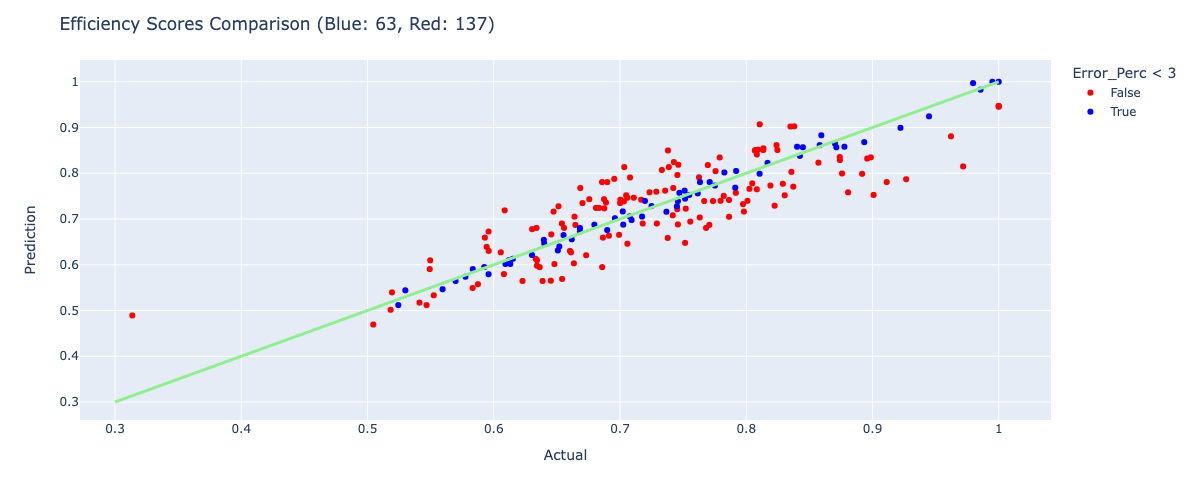

In [22]:
compareML(pipe_dt, y)

blue :  639
red :  361


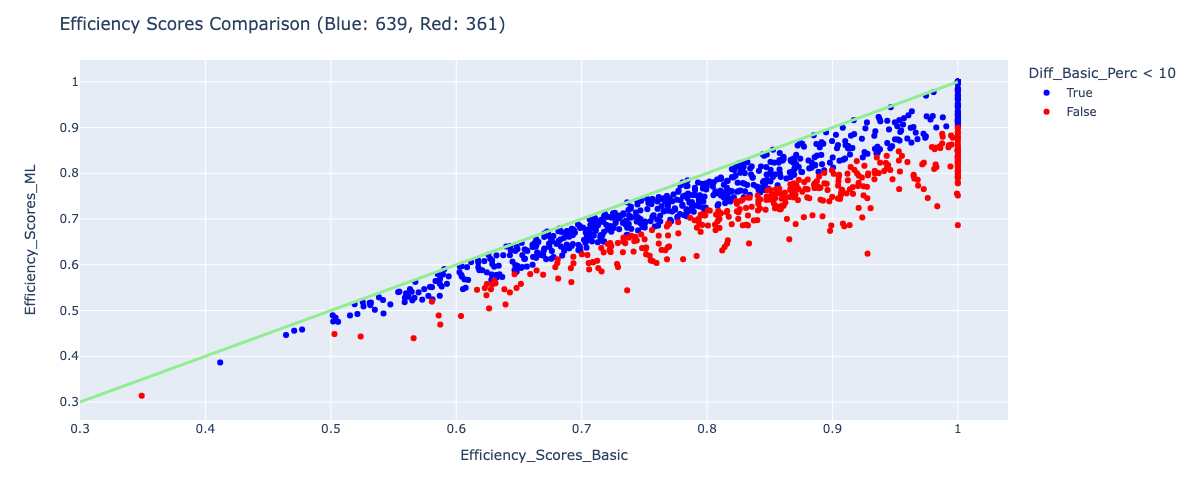

In [23]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_1.xlsx")

### i = 2

In [24]:
i +=1
i

2

In [25]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       1
Weight_Input 02     630
Weight_Input 03      26
Weight_Input 04     674
Weight_Input 05     780
Weight_Input 06       5
Weight_Input 07     349
Weight_Input 08       0
Weight_Input 09     864
Weight_Input 10     274
Weight_Input 11     337
Weight_Input 12      91
Weight_Output 01      0
dtype: int64
Total Zeros:  4031
neg_mean_squared_error: -0.0032173809353797872
neg_root_mean_squared_error: -0.056350025327769705
r2: 0.7430430486664964
grid.best_score:  -0.05167930620115213
grid.best_params:  {'decisiontreeregressor__max_depth': 12, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 10}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=12, max_features='auto',
                                       min_samples_split=10,
                                       random_state=42))])
grid.r2:  0.784295

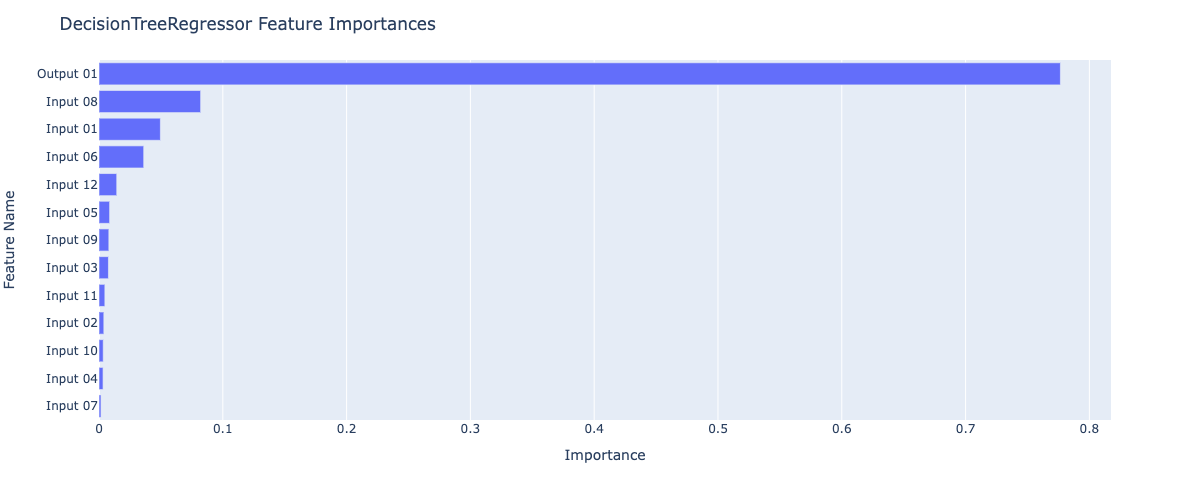

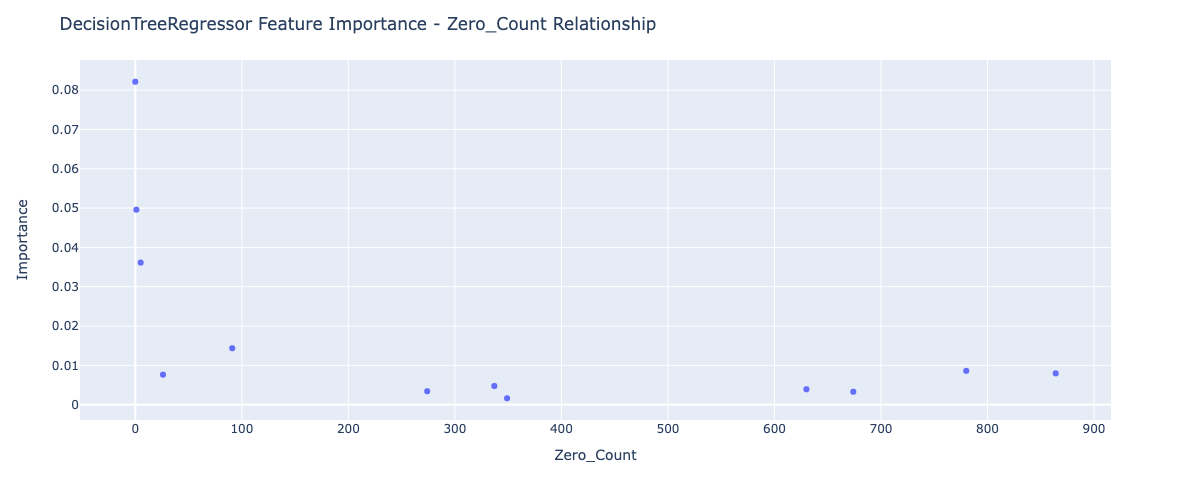

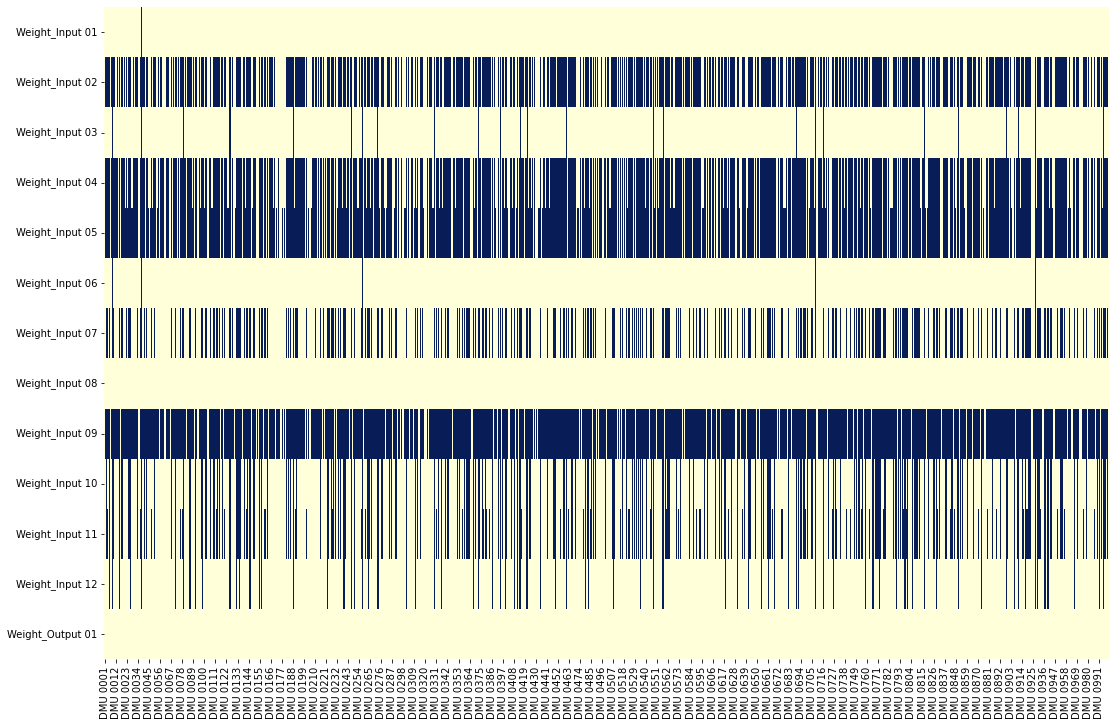

In [26]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_2.xlsx", i=i)
results.append(r)

In [27]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.807431  Output 01           0          0
1      Input 08    0.036786   Input 08         428          0
2      Input 01    0.030032   Input 01         330          0
3      Input 09    0.028091   Input 09         599          0
4      Input 03    0.025816   Input 03         249          0
5      Input 07    0.019504   Input 07         673          0
6      Input 06    0.018587   Input 06         396          0
7      Input 04    0.013899   Input 04         717          0
8      Input 11    0.010232   Input 11         742          0
9      Input 02    0.003346   Input 02         801          0
10     Input 05    0.003320   Input 05         681          0
11     Input 10    0.002958   Input 10         830          0
12     Input 12    0.000000   Input 12         757          0
13    Output 01    0.848902  Output 01           0          1
14     Input 08    0.101248   Input 08           0          1
15     Input 01    0.029756   Input 01           1          1
16     Input 06    0.005650   Input 06         102          1
17     Input 03    0.004647   Input 03           6          1
18     Input 12    0.004403   Input 12         862          1
19     Input 10    0.002196   Input 10         810          1
20     Input 11    0.002137   Input 11         494          1
21     Input 07    0.001061   Input 07          73          1
22     Input 02    0.000000   Input 02         662          1
23     Input 04    0.000000   Input 04         368          1
24     Input 05    0.000000   Input 05         772          1
25     Input 09    0.000000   Input 09           4          1
26    Output 01    0.776598  Output 01           0          2
27     Input 08    0.082124   Input 08           0          2
28     Input 01    0.049590   Input 01           1          2
29     Input 06    0.036136   Input 06           5          2
30     Input 12    0.014358   Input 12          91          2
31     Input 05    0.008600   Input 05         780          2
32     Input 09    0.007964   Input 09         864          2
33     Input 03    0.007625   Input 03          26          2
34     Input 11    0.004750   Input 11         337          2
35     Input 02    0.003914   Input 02         630          2
36     Input 10    0.003417   Input 10         274          2
37     Input 04    0.003289   Input 04         674          2
38     Input 07    0.001637   Input 07         349          2

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6899  0.6156  0.0743     12.0648           False
1        0.6250  0.6293 -0.0044     -0.6943            True
2        0.7891  0.7882  0.0008      0.1031            True
3        0.8264  0.8432 -0.0168     -1.9902            True
4        0.7825  0.7455  0.0370      4.9672           False
..          ...     ...     ...         ...             ...
195      0.8196  0.7370  0.0826     11.2071           False
196      0.8454  0.8236  0.0218      2.6441            True
197      0.7275  0.7860 -0.0585     -7.4430           False
198      0.7833  0.8226 -0.0393     -4.7834           False
199      0.7556  0.8261 -0.0706     -8.5445           False

[200 rows x 5 columns]
blue:  69
red:  131
rho: 0.8814
p-Value 0.0


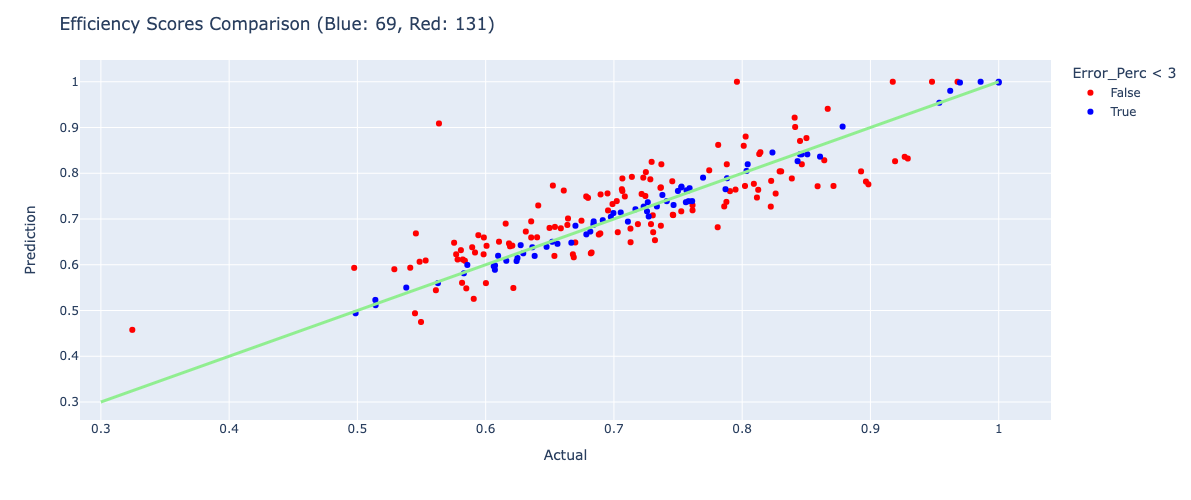

In [28]:
compareML(pipe_dt, y)

blue :  514
red :  486


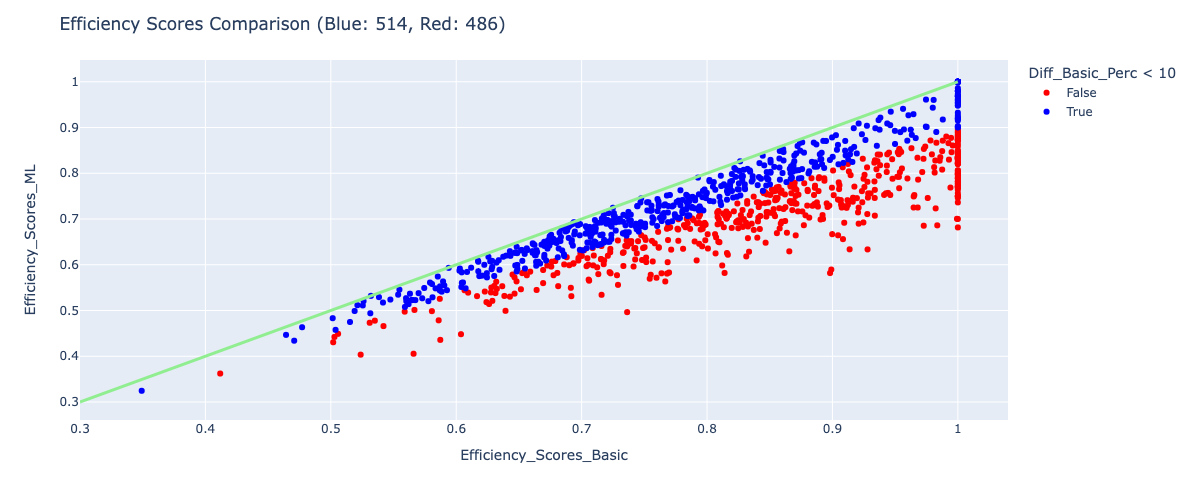

blue :  979
red :  21


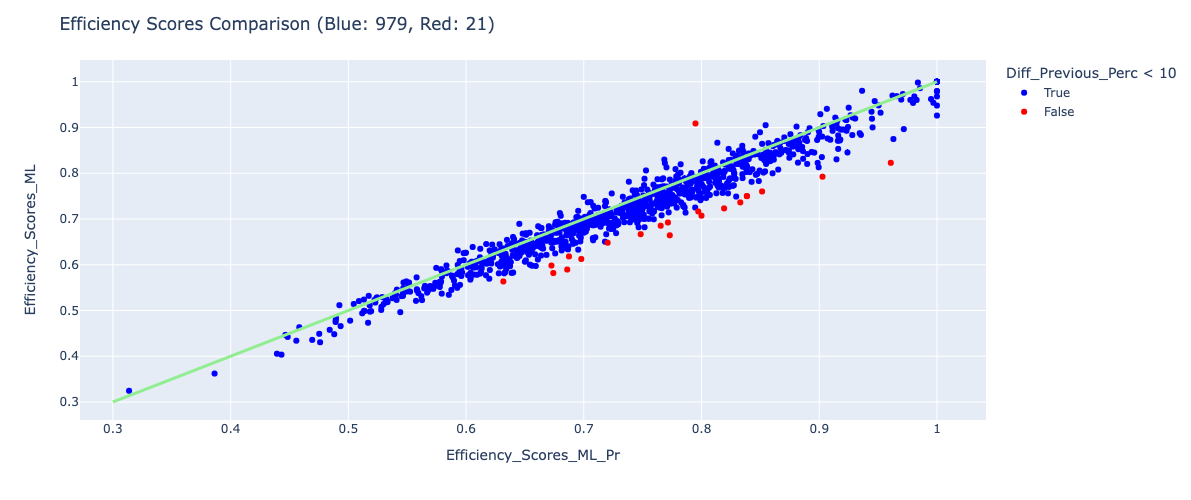

In [29]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_2.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_1.xlsx")

### i = 3

In [30]:
i +=1
i

3

In [31]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       0
Weight_Input 02     728
Weight_Input 03     176
Weight_Input 04     819
Weight_Input 05     116
Weight_Input 06       6
Weight_Input 07     867
Weight_Input 08       0
Weight_Input 09     157
Weight_Input 10     781
Weight_Input 11     344
Weight_Input 12      60
Weight_Output 01      0
dtype: int64
Total Zeros:  4054
neg_mean_squared_error: -0.0029434339693889594
neg_root_mean_squared_error: -0.05418664199221701
r2: 0.7740673199023487
grid.best_score:  -0.05051038807390423
grid.best_params:  {'decisiontreeregressor__max_depth': 9, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 10}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=9, max_features='auto',
                                       min_samples_split=10,
                                       random_state=42))])
grid.r2:  0.802026388

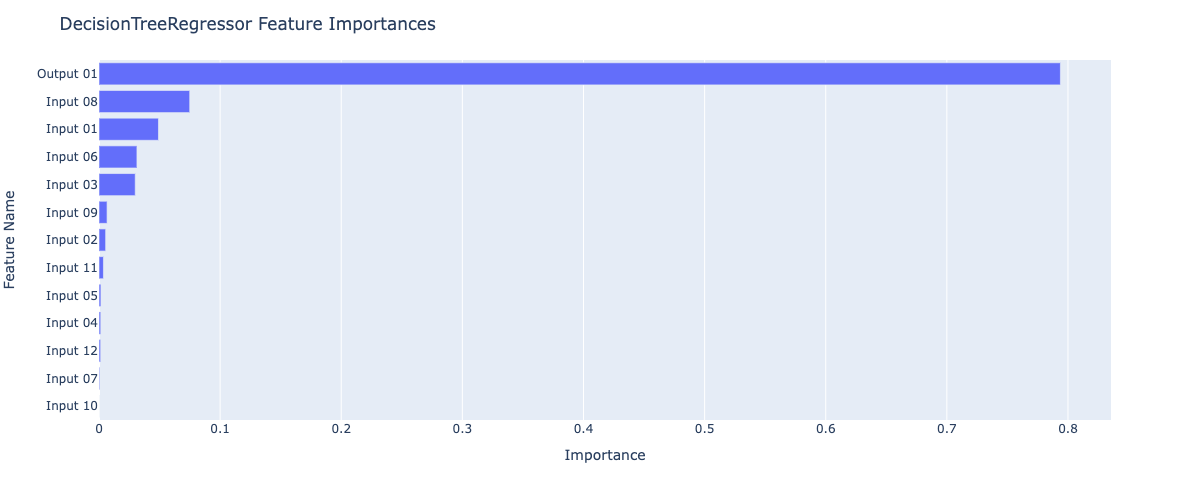

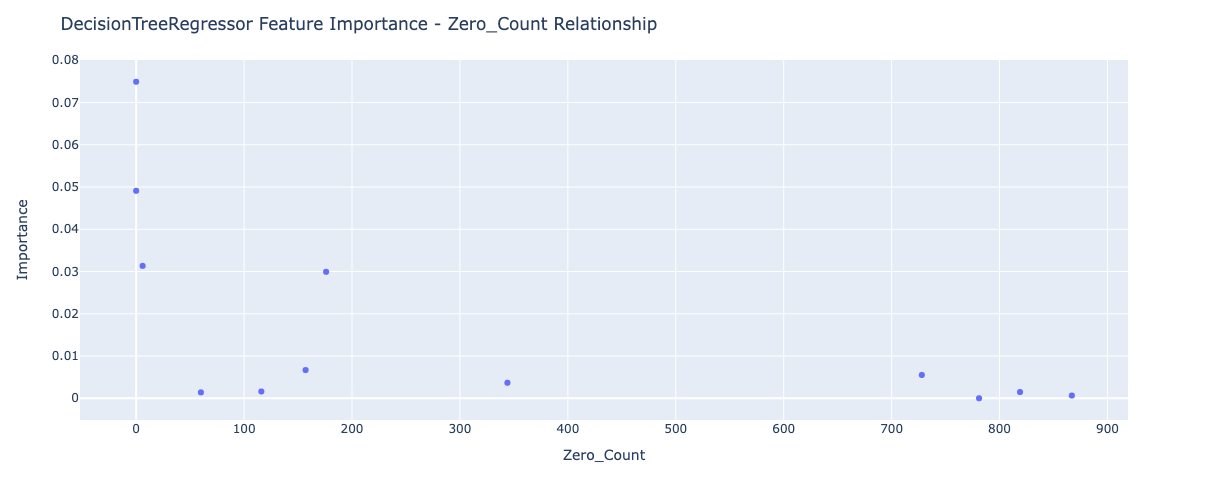

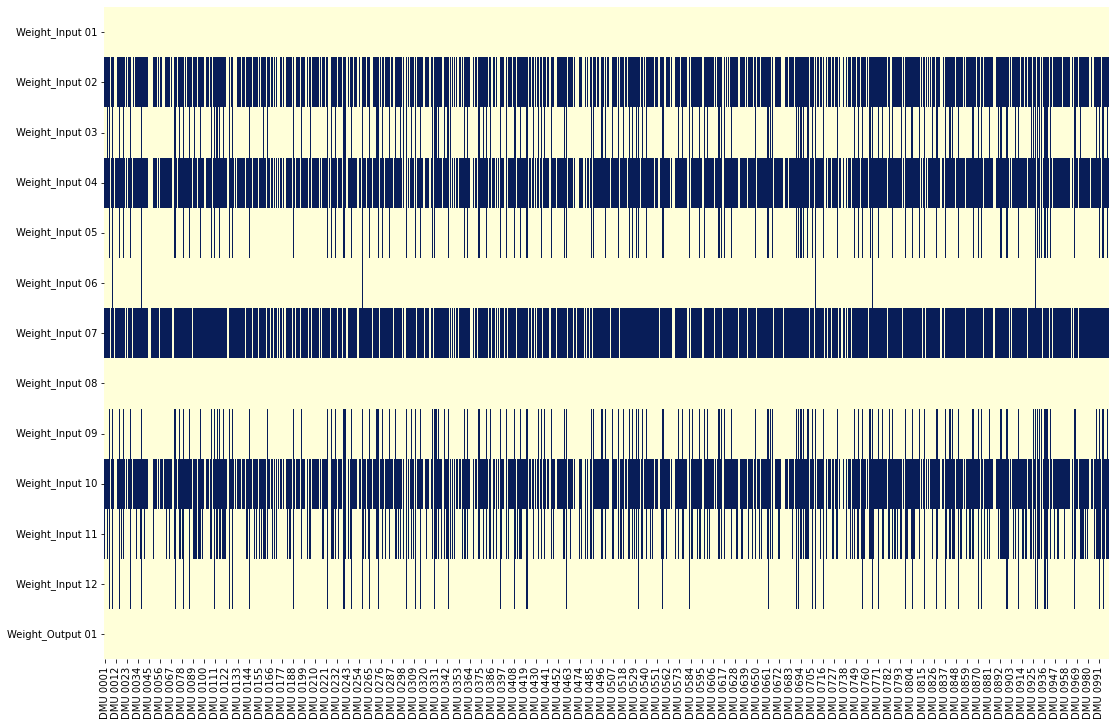

In [32]:
pipe_dt, r, y,df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_3.xlsx", i=i)
results.append(r)

In [33]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.807431  Output 01           0          0
1      Input 08    0.036786   Input 08         428          0
2      Input 01    0.030032   Input 01         330          0
3      Input 09    0.028091   Input 09         599          0
4      Input 03    0.025816   Input 03         249          0
5      Input 07    0.019504   Input 07         673          0
6      Input 06    0.018587   Input 06         396          0
7      Input 04    0.013899   Input 04         717          0
8      Input 11    0.010232   Input 11         742          0
9      Input 02    0.003346   Input 02         801          0
10     Input 05    0.003320   Input 05         681          0
11     Input 10    0.002958   Input 10         830          0
12     Input 12    0.000000   Input 12         757          0
13    Output 01    0.848902  Output 01           0          1
14     Input 08    0.101248   Input 08           0          1
15     Input 01    0.029756   Input 01           1          1
16     Input 06    0.005650   Input 06         102          1
17     Input 03    0.004647   Input 03           6          1
18     Input 12    0.004403   Input 12         862          1
19     Input 10    0.002196   Input 10         810          1
20     Input 11    0.002137   Input 11         494          1
21     Input 07    0.001061   Input 07          73          1
22     Input 02    0.000000   Input 02         662          1
23     Input 04    0.000000   Input 04         368          1
24     Input 05    0.000000   Input 05         772          1
25     Input 09    0.000000   Input 09           4          1
26    Output 01    0.776598  Output 01           0          2
27     Input 08    0.082124   Input 08           0          2
28     Input 01    0.049590   Input 01           1          2
29     Input 06    0.036136   Input 06           5          2
30     Input 12    0.014358   Input 12          91          2
31     Input 05    0.008600   Input 05         780          2
32     Input 09    0.007964   Input 09         864          2
33     Input 03    0.007625   Input 03          26          2
34     Input 11    0.004750   Input 11         337          2
35     Input 02    0.003914   Input 02         630          2
36     Input 10    0.003417   Input 10         274          2
37     Input 04    0.003289   Input 04         674          2
38     Input 07    0.001637   Input 07         349          2
39    Output 01    0.793755  Output 01           0          3
40     Input 08    0.074920   Input 08           0          3
41     Input 01    0.049106   Input 01           0          3
42     Input 06    0.031333   Input 06           6          3
43     Input 03    0.029930   Input 03         176          3
44     Input 09    0.006670   Input 09         157          3
45     Input 02    0.005508   Input 02         728          3
46     Input 11    0.003664   Input 11         344          3
47     Input 05    0.001603   Input 05         116          3
48     Input 04    0.001470   Input 04         819          3
49     Input 12    0.001394   Input 12          60          3
50     Input 07    0.000647   Input 07         867          3
51     Input 10    0.000000   Input 10         781          3

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.5452  0.6203 -0.0751    -12.1143           False
1        0.5991  0.6213 -0.0222     -3.5744           False
2        0.8344  0.8108  0.0236      2.9160            True
3        0.7522  0.8474 -0.0951    -11.2261           False
4        0.7039  0.7435 -0.0396     -5.3217           False
..          ...     ...     ...         ...             ...
195      0.7085  0.7357 -0.0272     -3.7015           False
196      0.7343  0.8359 -0.1016    -12.1537           False
197      0.7283  0.7824 -0.0541     -6.9101           False
198      0.7644  0.8225 -0.0581     -7.0607           False
199      0.7745  0.8261 -0.0517     -6.2545           False

[200 rows x 5 columns]
blue:  70
red:  130
rho: 0.8775
p-Value 0.0


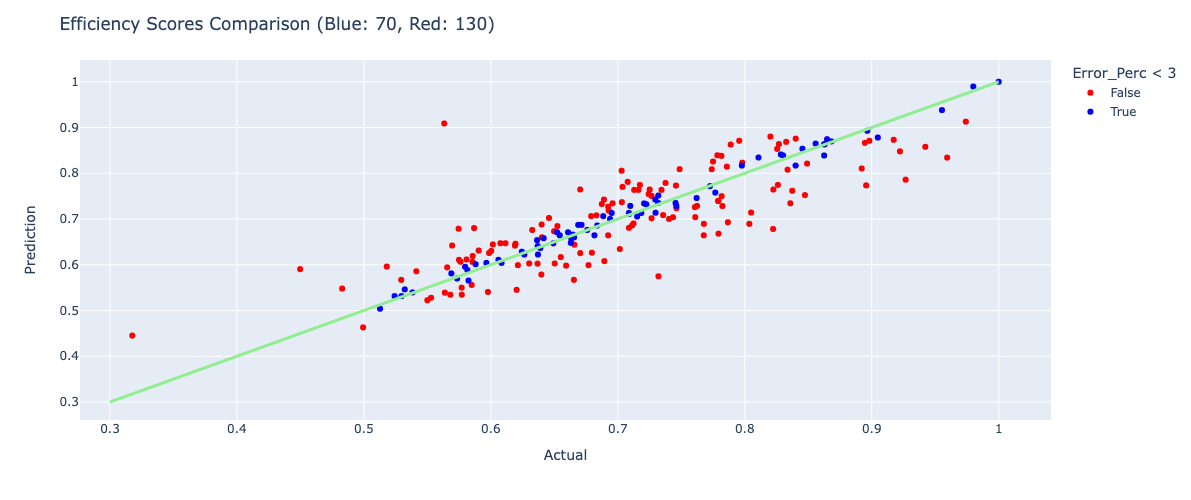

In [34]:
compareML(pipe_dt, y)

blue :  436
red :  564


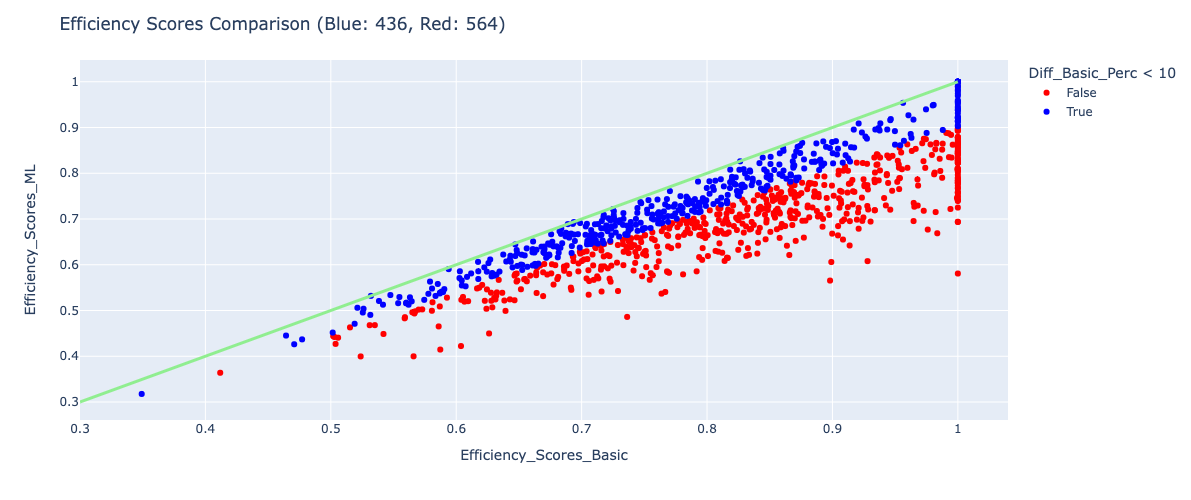

blue :  997
red :  3


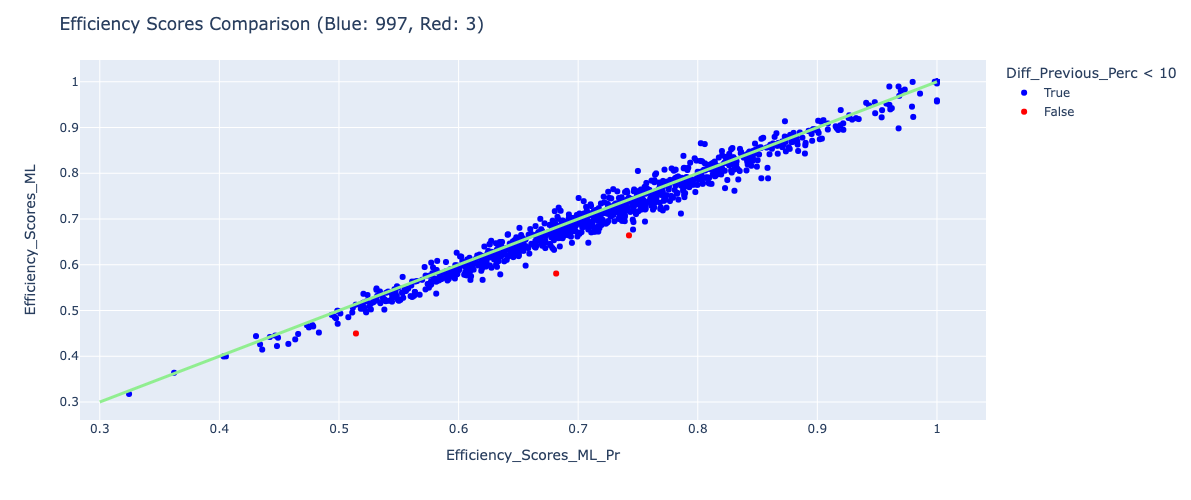

In [35]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_3.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_2.xlsx")

### i = 4

In [36]:
i +=1
i

4

In [37]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       1
Weight_Input 02     147
Weight_Input 03      25
Weight_Input 04     289
Weight_Input 05     226
Weight_Input 06       5
Weight_Input 07     465
Weight_Input 08       0
Weight_Input 09      85
Weight_Input 10     673
Weight_Input 11     176
Weight_Input 12     380
Weight_Output 01      0
dtype: int64
Total Zeros:  2472
neg_mean_squared_error: -0.0031601328077968034
neg_root_mean_squared_error: -0.0561885602236528
r2: 0.7438038270961629
grid.best_score:  -0.05427260784312088
grid.best_params:  {'decisiontreeregressor__max_depth': 13, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 20}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=13, max_features='auto',
                                       min_samples_split=20,
                                       random_state=42))])
grid.r2:  0.76087806

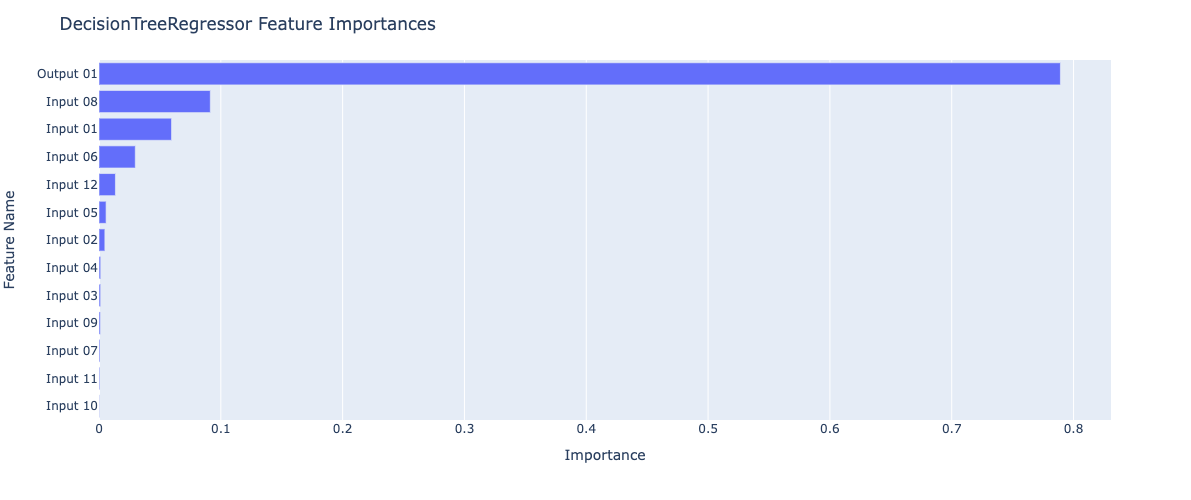

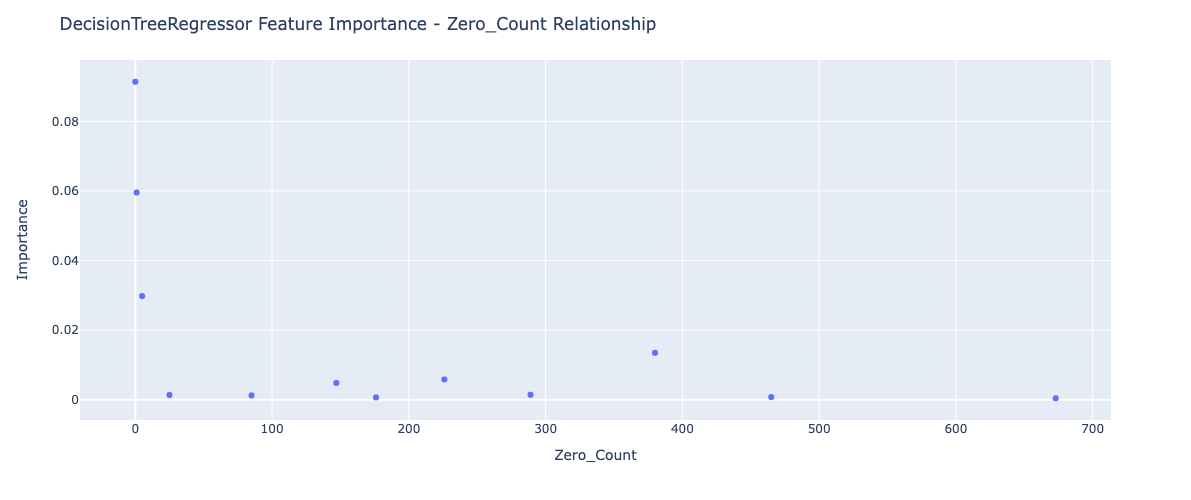

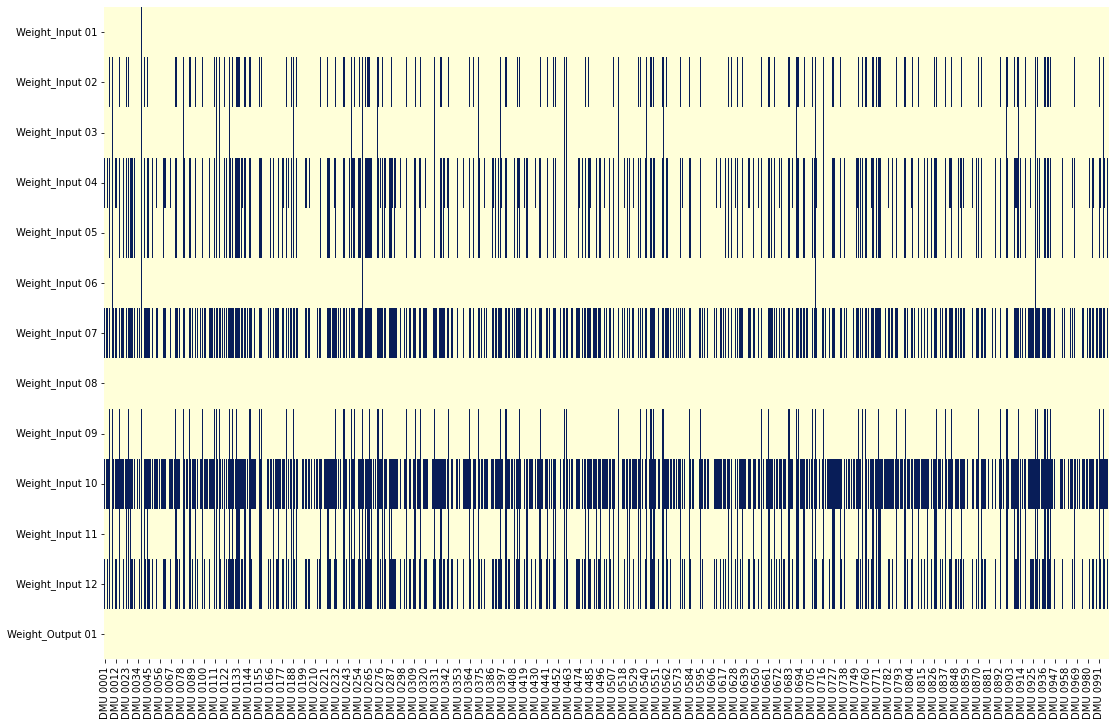

In [38]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_4.xlsx", i=i)
results.append(r)

In [39]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.807431  Output 01           0          0
1      Input 08    0.036786   Input 08         428          0
2      Input 01    0.030032   Input 01         330          0
3      Input 09    0.028091   Input 09         599          0
4      Input 03    0.025816   Input 03         249          0
..          ...         ...        ...         ...        ...
60     Input 03    0.001371   Input 03          25          4
61     Input 09    0.001245   Input 09          85          4
62     Input 07    0.000769   Input 07         465          4
63     Input 11    0.000673   Input 11         176          4
64     Input 10    0.000427   Input 10         673          4

[65 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7653  0.6218  0.1435     23.0765           False
1        0.5705  0.6221 -0.0516     -8.2890           False
2        0.7190  0.7847 -0.0657     -8.3724           False
3        0.8812  0.8287  0.0525      6.3350           False
4        0.6958  0.7583 -0.0625     -8.2427           False
..          ...     ...     ...         ...             ...
195      0.8079  0.7422  0.0657      8.8520           False
196      0.8663  0.8076  0.0587      7.2646           False
197      0.7143  0.7799 -0.0656     -8.4126           False
198      0.7783  0.8393 -0.0610     -7.2682           False
199      0.8115  0.8261 -0.0146     -1.7718            True

[200 rows x 5 columns]
blue:  72
red:  128
rho: 0.8597
p-Value 0.0


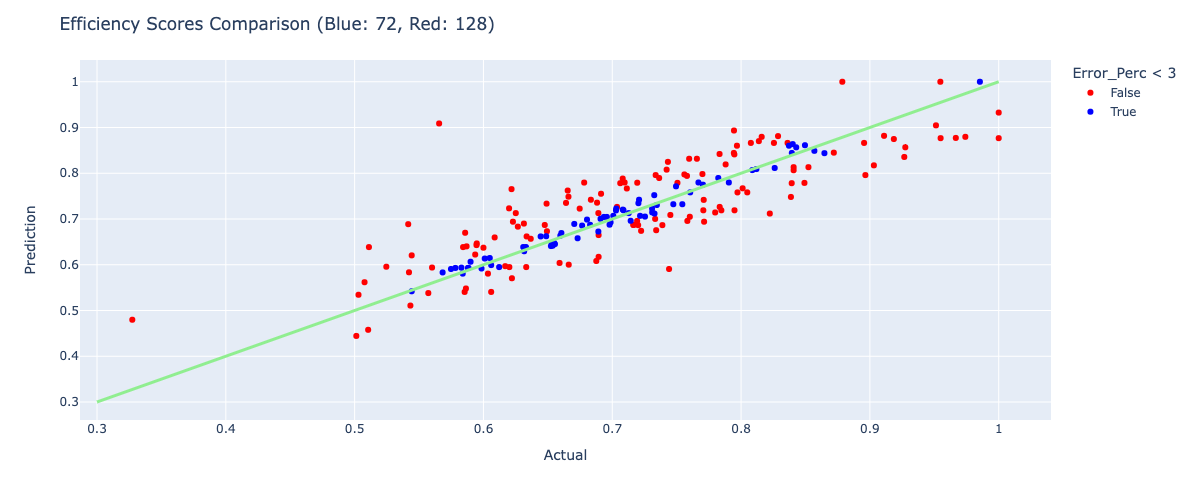

In [40]:
compareML(pipe_dt, y)

blue :  493
red :  507


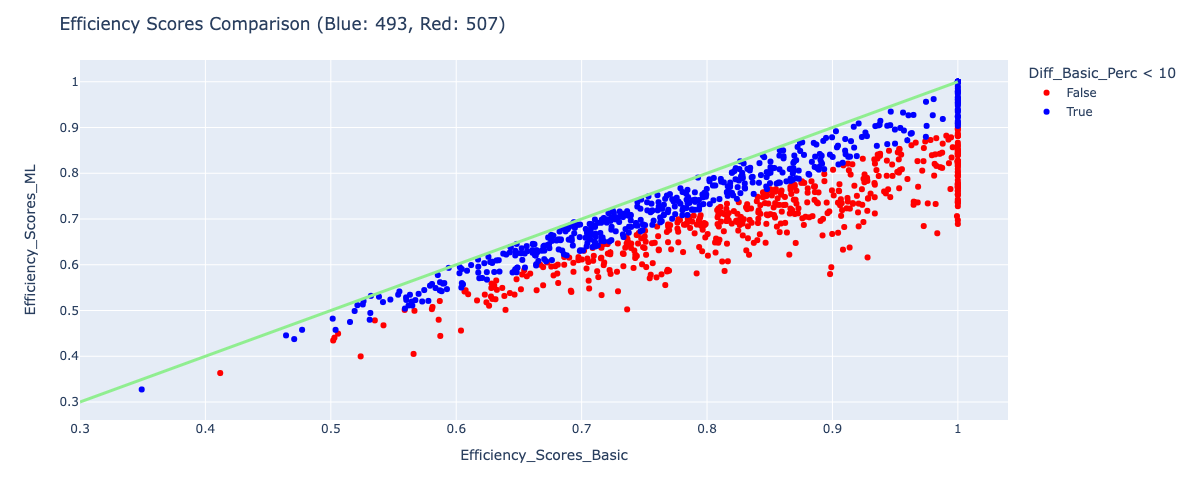

blue :  997
red :  3


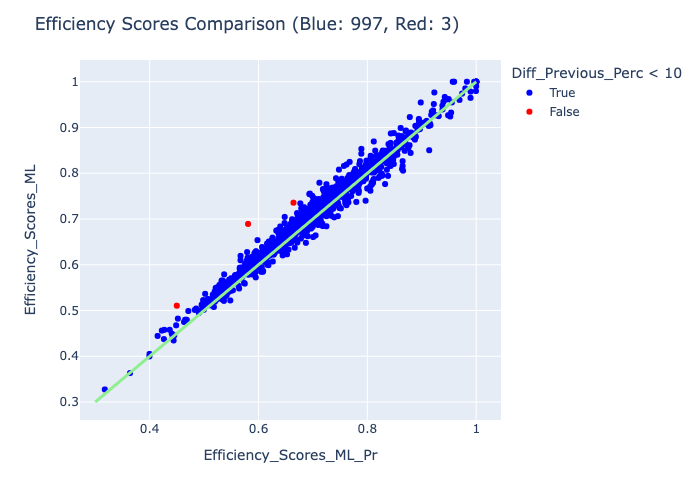

In [41]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_4.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_3.xlsx")

### i = 5

In [42]:
i +=1
i

5

In [43]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       1
Weight_Input 02     407
Weight_Input 03     437
Weight_Input 04     427
Weight_Input 05     129
Weight_Input 06       6
Weight_Input 07     544
Weight_Input 08       0
Weight_Input 09     516
Weight_Input 10     714
Weight_Input 11     546
Weight_Input 12      68
Weight_Output 01      0
dtype: int64
Total Zeros:  3795
neg_mean_squared_error: -0.0028430010693216512
neg_root_mean_squared_error: -0.053259227968047315
r2: 0.7832905040008095
grid.best_score:  -0.05100479642696539
grid.best_params:  {'decisiontreeregressor__max_depth': 11, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 10}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=11, max_features='auto',
                                       min_samples_split=10,
                                       random_state=42))])
grid.r2:  0.801800

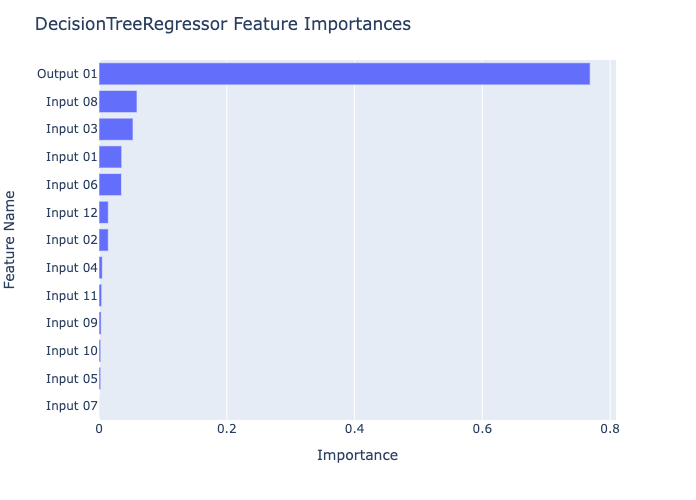

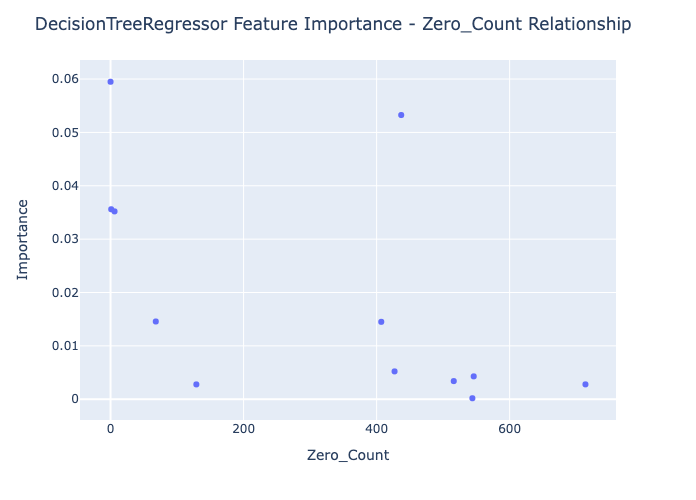

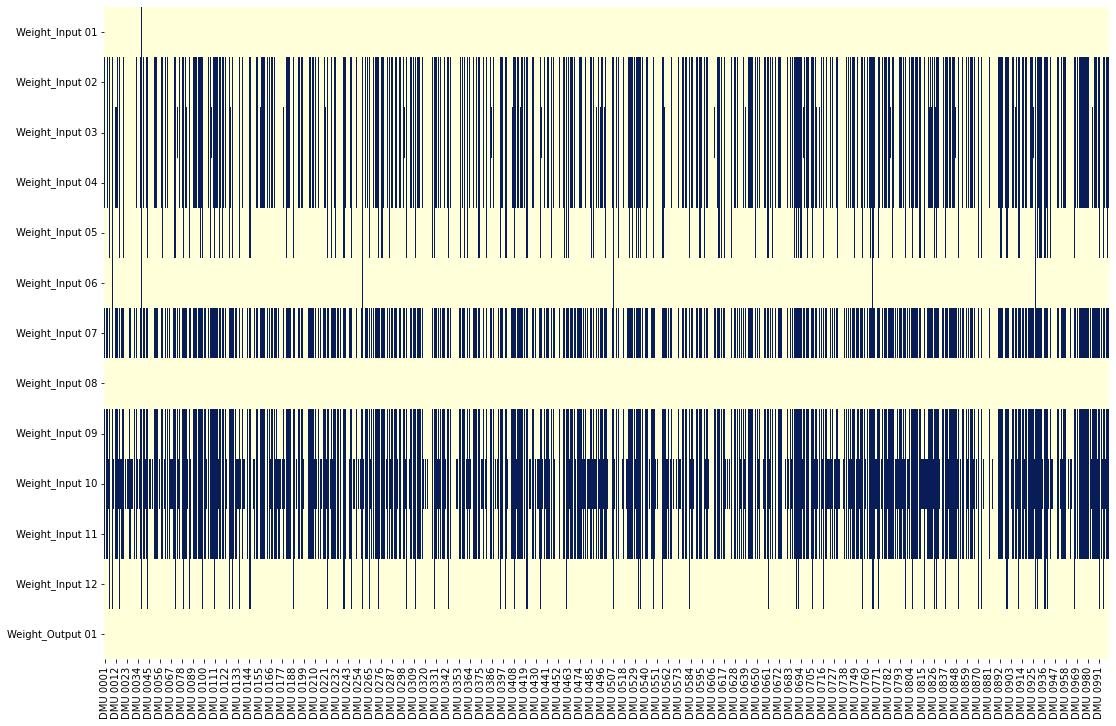

In [44]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_5.xlsx", i=i)
results.append(r)

In [45]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.807431  Output 01           0          0
1      Input 08    0.036786   Input 08         428          0
2      Input 01    0.030032   Input 01         330          0
3      Input 09    0.028091   Input 09         599          0
4      Input 03    0.025816   Input 03         249          0
..          ...         ...        ...         ...        ...
73     Input 11    0.004284   Input 11         546          5
74     Input 09    0.003400   Input 09         516          5
75     Input 10    0.002782   Input 10         714          5
76     Input 05    0.002777   Input 05         129          5
77     Input 07    0.000183   Input 07         544          5

[78 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7101  0.6152  0.0949     15.4220           False
1        0.6567  0.6166  0.0401      6.4993           False
2        0.8551  0.7948  0.0603      7.5931           False
3        0.8647  0.8474  0.0173      2.0471            True
4        0.7168  0.7288 -0.0119     -1.6392            True
..          ...     ...     ...         ...             ...
195      0.7478  0.7357  0.0121      1.6422            True
196      0.8691  0.8359  0.0332      3.9661           False
197      0.7161  0.7789 -0.0628     -8.0623           False
198      0.7239  0.7982 -0.0743     -9.3103           False
199      0.7689  0.8261 -0.0573     -6.9340           False

[200 rows x 5 columns]
blue:  68
red:  132
rho: 0.8543
p-Value 0.0


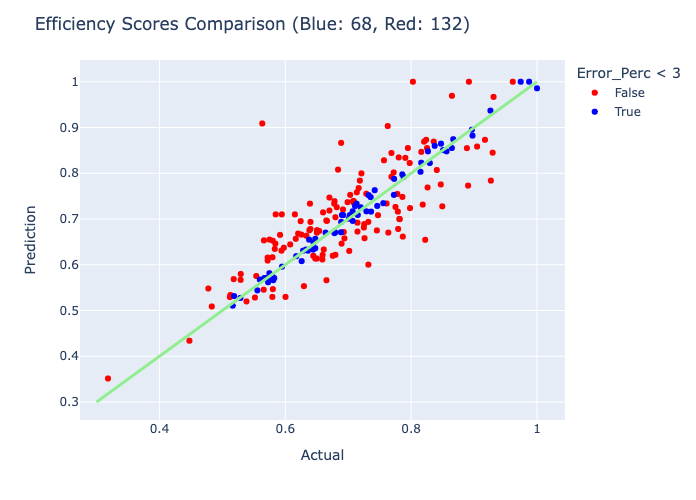

In [46]:
compareML(pipe_dt, y)

blue :  404
red :  596


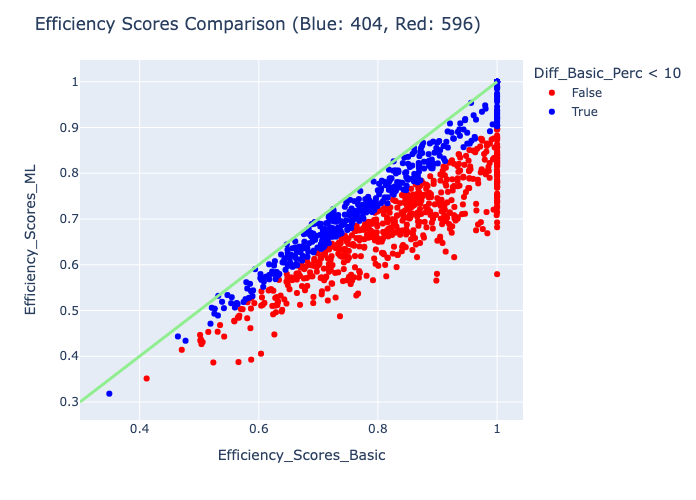

blue :  994
red :  6


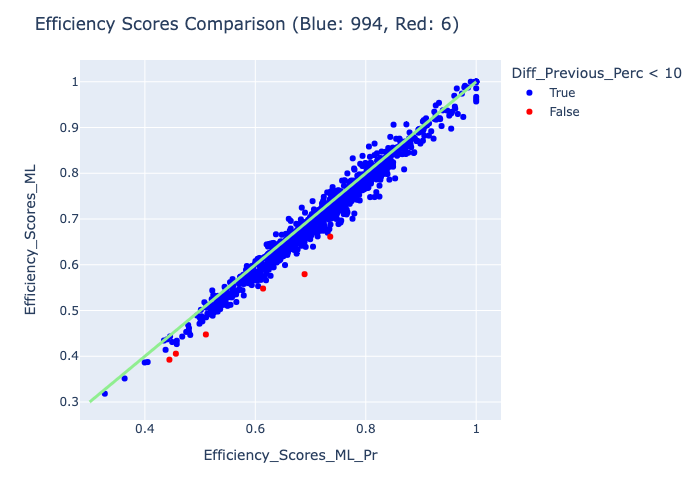

In [47]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_5.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_4.xlsx")

### i = 6

In [48]:
i +=1
i

6

In [49]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       5
Weight_Input 02     592
Weight_Input 03       1
Weight_Input 04     680
Weight_Input 05     776
Weight_Input 06     117
Weight_Input 07     793
Weight_Input 08       0
Weight_Input 09     740
Weight_Input 10     764
Weight_Input 11     696
Weight_Input 12     166
Weight_Output 01      0
dtype: int64
Total Zeros:  5330
neg_mean_squared_error: -0.0033732841199673206
neg_root_mean_squared_error: -0.058017094824023986
r2: 0.7162740498364448
grid.best_score:  -0.052894307131830895
grid.best_params:  {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 30}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=10, max_features='auto',
                                       min_samples_split=30,
                                       random_state=42))])
grid.r2:  0.76268

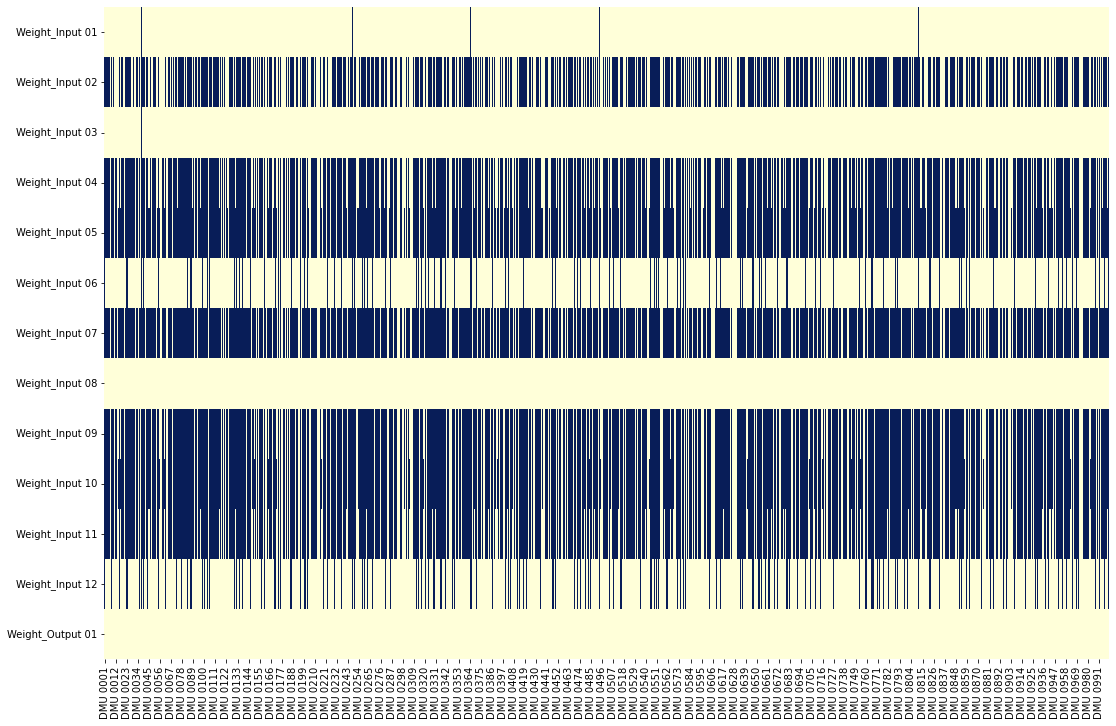

In [50]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_6.xlsx", i=i)
results.append(r)

In [51]:
compareML(pipe_dt, y)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7417  0.6090  0.1327     21.7970           False
1        0.6066  0.6962 -0.0896    -12.8730           False
2        0.8060  0.7947  0.0113      1.4222            True
3        0.9060  0.8449  0.0611      7.2329           False
4        0.7465  0.7447  0.0018      0.2449            True
..          ...     ...     ...         ...             ...
195      0.6747  0.7068 -0.0321     -4.5448           False
196      0.9105  0.8247  0.0858     10.4093           False
197      0.8025  0.7603  0.0422      5.5534           False
198      0.7864  0.8447 -0.0583     -6.9005           False
199      0.7893  0.7825  0.0068      0.8695            True

[200 rows x 5 columns]
blue:  69
red:  131
rho: 0.8498
p-Value 0.0


In [52]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0     Output 01    0.807431  Output 01           0          0
1      Input 08    0.036786   Input 08         428          0
2      Input 01    0.030032   Input 01         330          0
3      Input 09    0.028091   Input 09         599          0
4      Input 03    0.025816   Input 03         249          0
..          ...         ...        ...         ...        ...
86     Input 04    0.000000   Input 04         680          6
87     Input 09    0.000000   Input 09         740          6
88     Input 10    0.000000   Input 10         764          6
89     Input 11    0.000000   Input 11         696          6
90     Input 12    0.000000   Input 12         166          6

[91 rows x 5 columns]

In [53]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_6.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_5.xlsx")

blue :  561
red :  439


blue :  841
red :  159


### i = 7

In [54]:
i +=1
i

7

In [55]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01      16
Weight_Input 02     471
Weight_Input 03       1
Weight_Input 04     497
Weight_Input 05      53
Weight_Input 06      12
Weight_Input 07     476
Weight_Input 08       0
Weight_Input 09     510
Weight_Input 10     510
Weight_Input 11     513
Weight_Input 12     520
Weight_Output 01      0
dtype: int64
Total Zeros:  3579
neg_mean_squared_error: -0.003197170809322444
neg_root_mean_squared_error: -0.05644743322885283
r2: 0.7492677680283842
grid.best_score:  -0.052574850424497874
grid.best_params:  {'decisiontreeregressor__max_depth': 11, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 30}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=11, max_features='auto',
                                       min_samples_split=30,
                                       random_state=42))])
grid.r2:  0.7835688

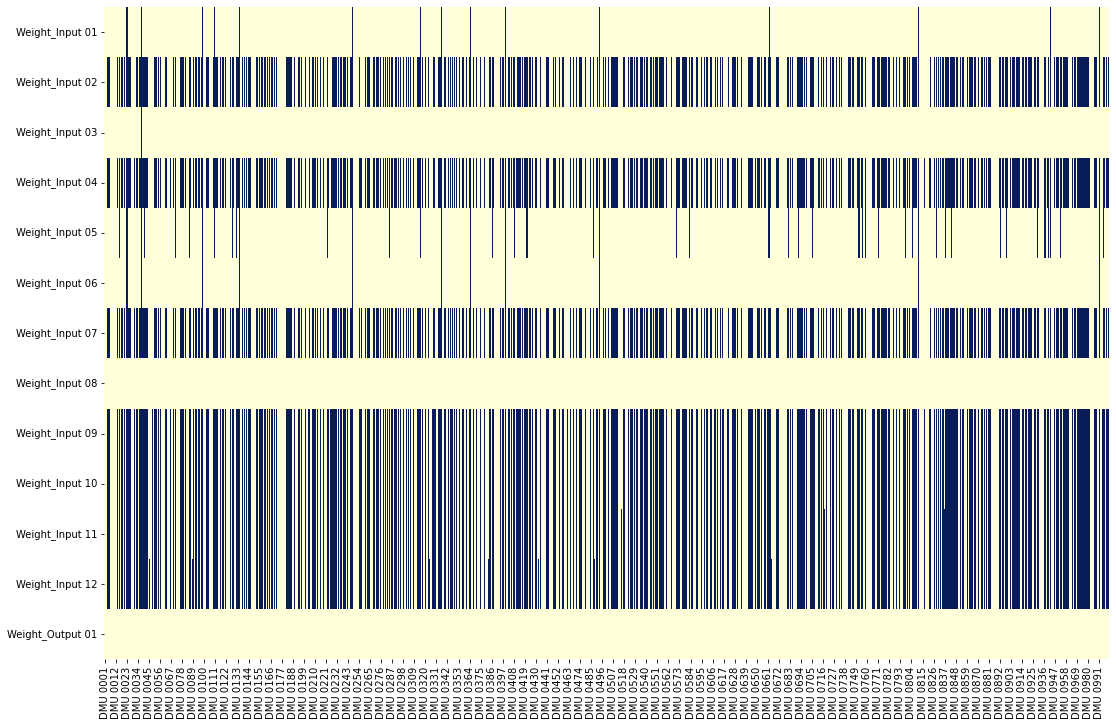

In [56]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_7.xlsx", i=i)
results.append(r)

In [57]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.807431  Output 01           0          0
1       Input 08    0.036786   Input 08         428          0
2       Input 01    0.030032   Input 01         330          0
3       Input 09    0.028091   Input 09         599          0
4       Input 03    0.025816   Input 03         249          0
..           ...         ...        ...         ...        ...
99      Input 04    0.001266   Input 04         497          7
100     Input 07    0.000940   Input 07         476          7
101     Input 10    0.000798   Input 10         510          7
102     Input 11    0.000599   Input 11         513          7
103     Input 02    0.000000   Input 02         471          7

[104 rows x 5 columns]

In [58]:
compareML(pipe_dt, y)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6797  0.6649  0.0149      2.2359            True
1        0.6638  0.6961 -0.0323     -4.6398           False
2        0.7392  0.7863 -0.0471     -5.9958           False
3        0.8371  0.8250  0.0121      1.4684            True
4        0.6062  0.7239 -0.1177    -16.2643           False
..          ...     ...     ...         ...             ...
195      0.6370  0.6751 -0.0381     -5.6407           False
196      0.7935  0.8133 -0.0198     -2.4305            True
197      0.7831  0.7335  0.0496      6.7642           False
198      0.7025  0.7789 -0.0764     -9.8131           False
199      0.7427  0.7565 -0.0138     -1.8213            True

[200 rows x 5 columns]
blue:  79
red:  121
rho: 0.8741
p-Value 0.0


blue :  305
red :  695


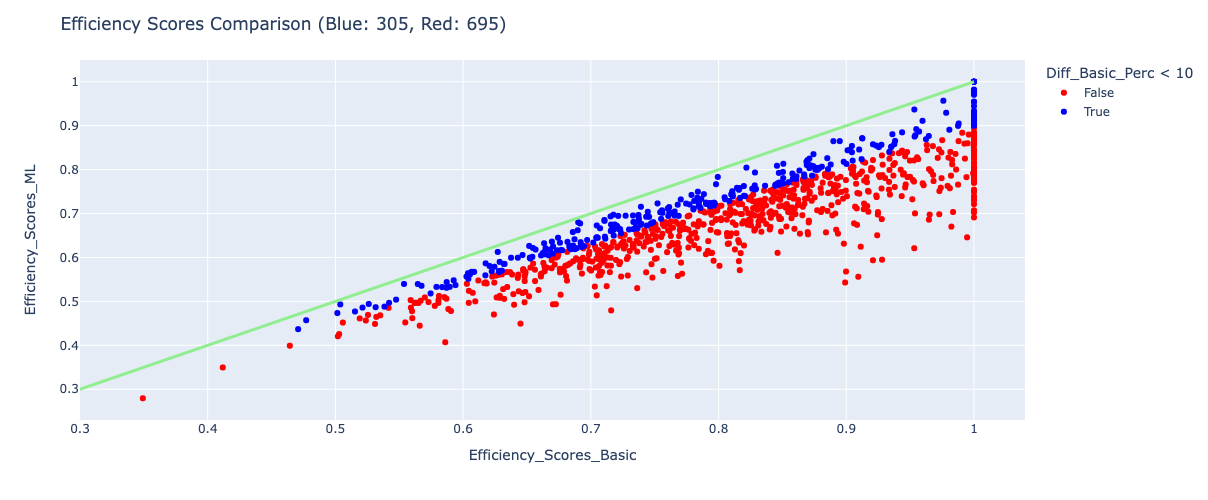

blue :  888
red :  112


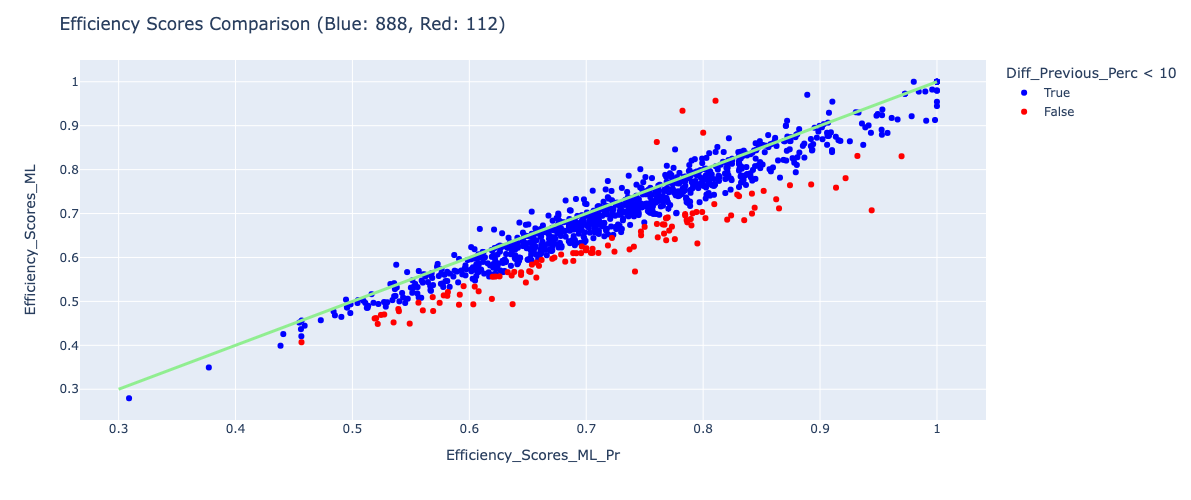

In [59]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_7.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_6.xlsx")

### i = 8

In [60]:
i +=1
i

8

In [61]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       3
Weight_Input 02     947
Weight_Input 03       2
Weight_Input 04     470
Weight_Input 05     276
Weight_Input 06       0
Weight_Input 07     474
Weight_Input 08       1
Weight_Input 09     173
Weight_Input 10     497
Weight_Input 11     695
Weight_Input 12       6
Weight_Output 01      0
dtype: int64
Total Zeros:  3544
neg_mean_squared_error: -0.002282407300102229
neg_root_mean_squared_error: -0.04767788178664287
r2: 0.8050190449419625
grid.best_score:  -0.04134484326894286
grid.best_params:  {'decisiontreeregressor__max_depth': 7, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 30}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=7, max_features='auto',
                                       min_samples_split=30,
                                       random_state=42))])
grid.r2:  0.8535780585

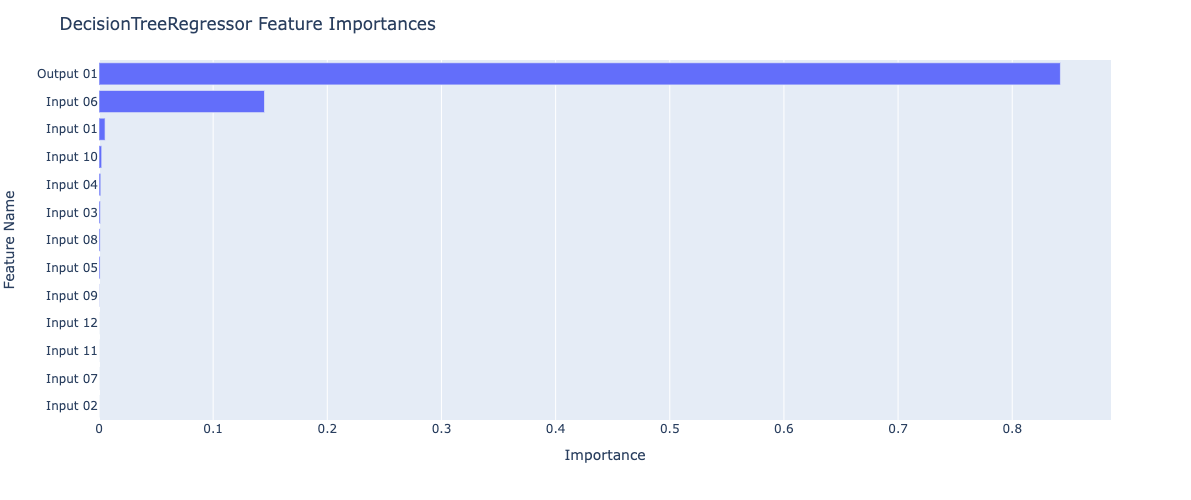

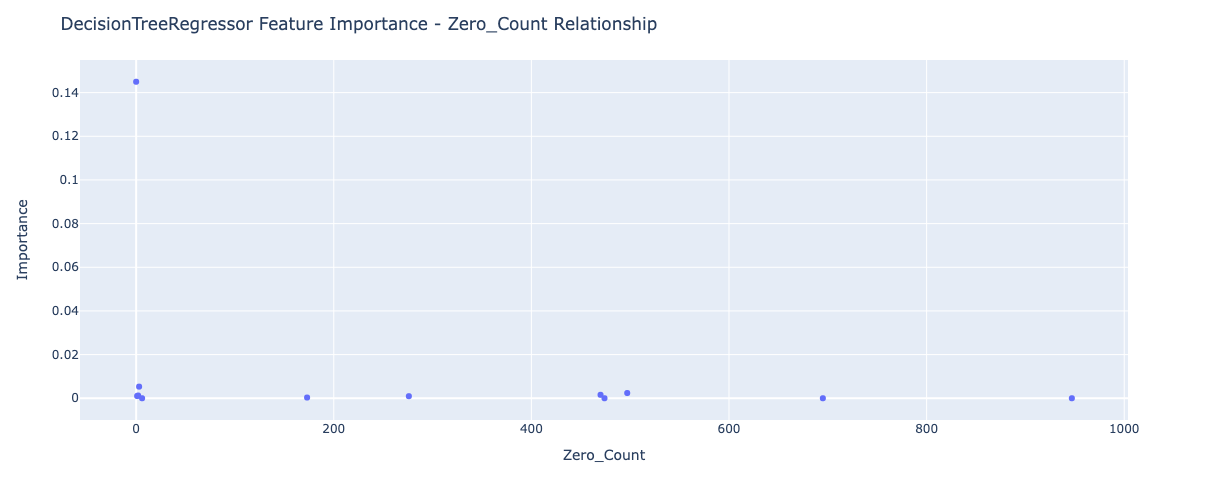

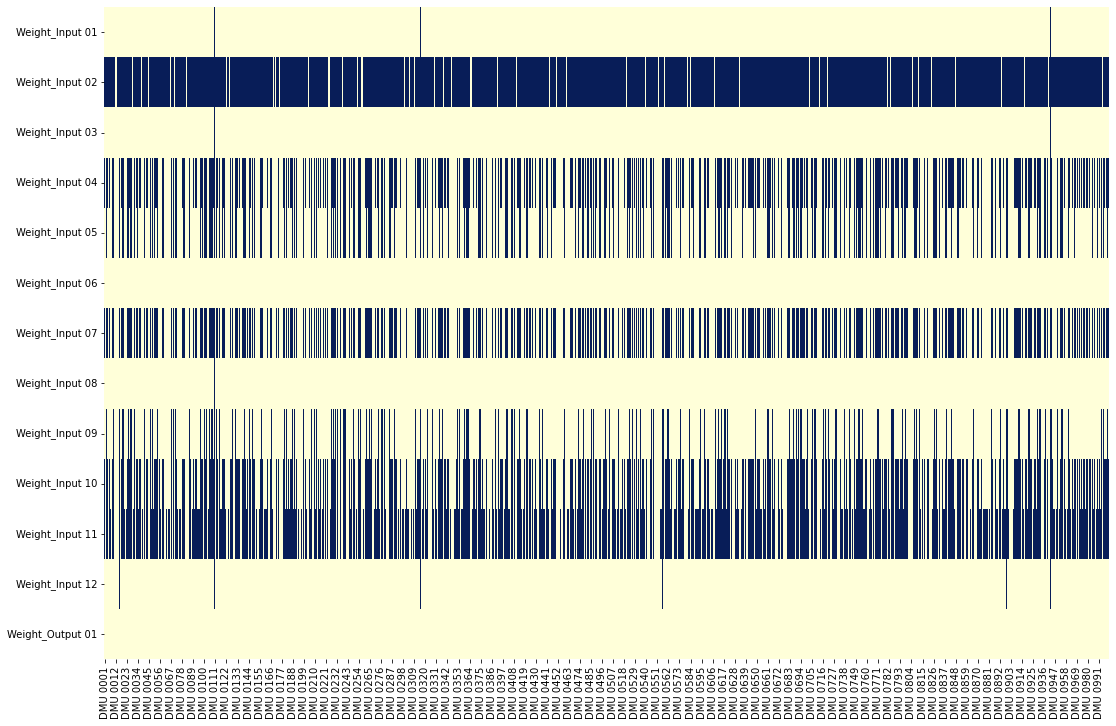

In [62]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_8.xlsx", i=i)
results.append(r)

In [63]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.807431  Output 01           0          0
1       Input 08    0.036786   Input 08         428          0
2       Input 01    0.030032   Input 01         330          0
3       Input 09    0.028091   Input 09         599          0
4       Input 03    0.025816   Input 03         249          0
..           ...         ...        ...         ...        ...
112     Input 09    0.000324   Input 09         173          8
113     Input 02    0.000000   Input 02         947          8
114     Input 07    0.000000   Input 07         474          8
115     Input 11    0.000000   Input 11         695          8
116     Input 12    0.000000   Input 12           6          8

[117 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.5926  0.6091 -0.0165     -2.7170            True
1        0.6259  0.6082  0.0177      2.9070            True
2        0.8100  0.7944  0.0156      1.9611            True
3        0.8844  0.8197  0.0647      7.8912           False
4        0.6800  0.6565  0.0235      3.5723           False
..          ...     ...     ...         ...             ...
195      0.6448  0.6830 -0.0381     -5.5814           False
196      0.7950  0.7836  0.0115      1.4630            True
197      0.7421  0.7342  0.0078      1.0690            True
198      0.6921  0.7298 -0.0377     -5.1619           False
199      0.6923  0.7529 -0.0606     -8.0469           False

[200 rows x 5 columns]
blue:  82
red:  118
rho: 0.8821
p-Value 0.0


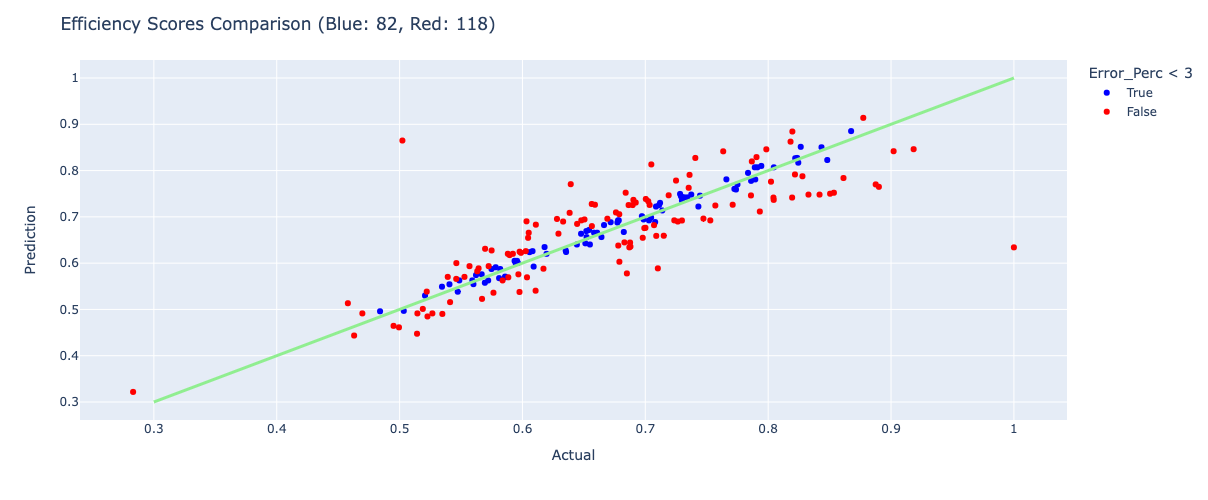

In [64]:
compareML(pipe_dt, y)

blue :  136
red :  864


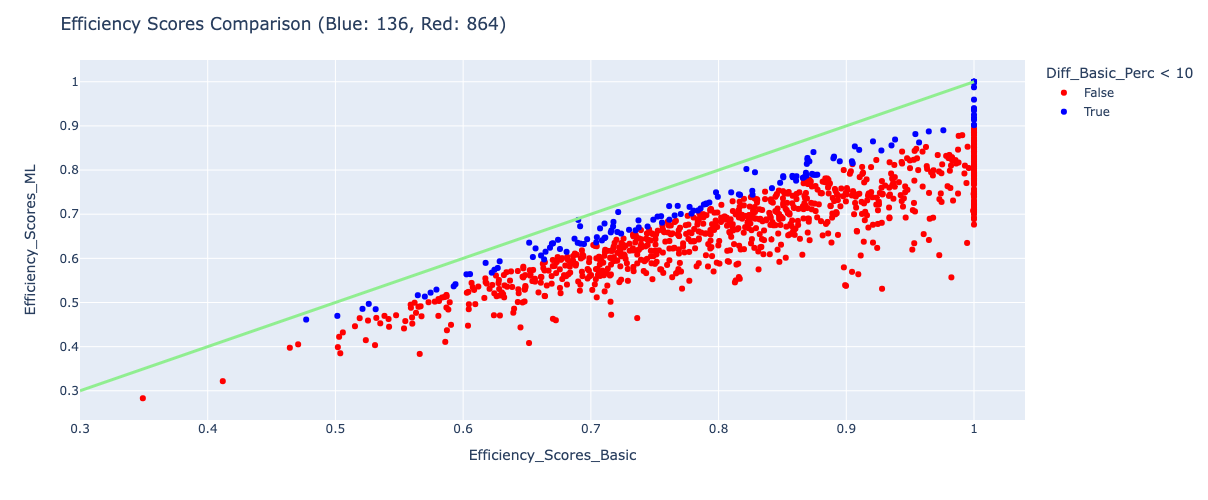

blue :  901
red :  99


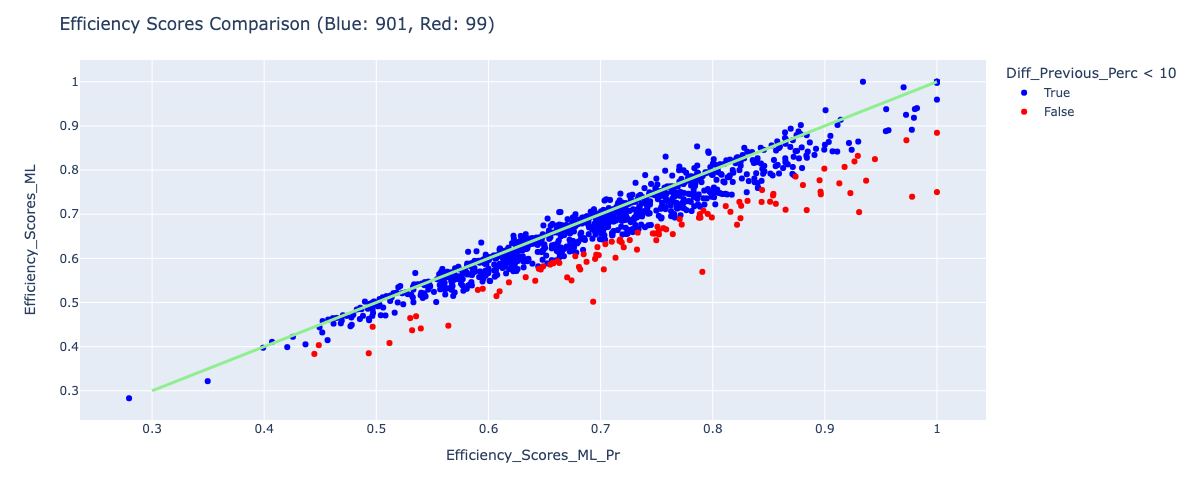

In [65]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_8.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_7.xlsx")

### i = 9

In [66]:
i +=1
i

9

In [67]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       2
Weight_Input 02     936
Weight_Input 03     414
Weight_Input 04     397
Weight_Input 05     612
Weight_Input 06       0
Weight_Input 07     942
Weight_Input 08     450
Weight_Input 09     713
Weight_Input 10     135
Weight_Input 11     951
Weight_Input 12     964
Weight_Output 01      0
dtype: int64
Total Zeros:  6516
neg_mean_squared_error: -0.002205679799517085
neg_root_mean_squared_error: -0.04668685035815721
r2: 0.8350650106026964
grid.best_score:  -0.04483188087422816
grid.best_params:  {'decisiontreeregressor__max_depth': 9, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 20}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=9, max_features='auto',
                                       min_samples_split=20,
                                       random_state=42))])
grid.r2:  0.8470203266

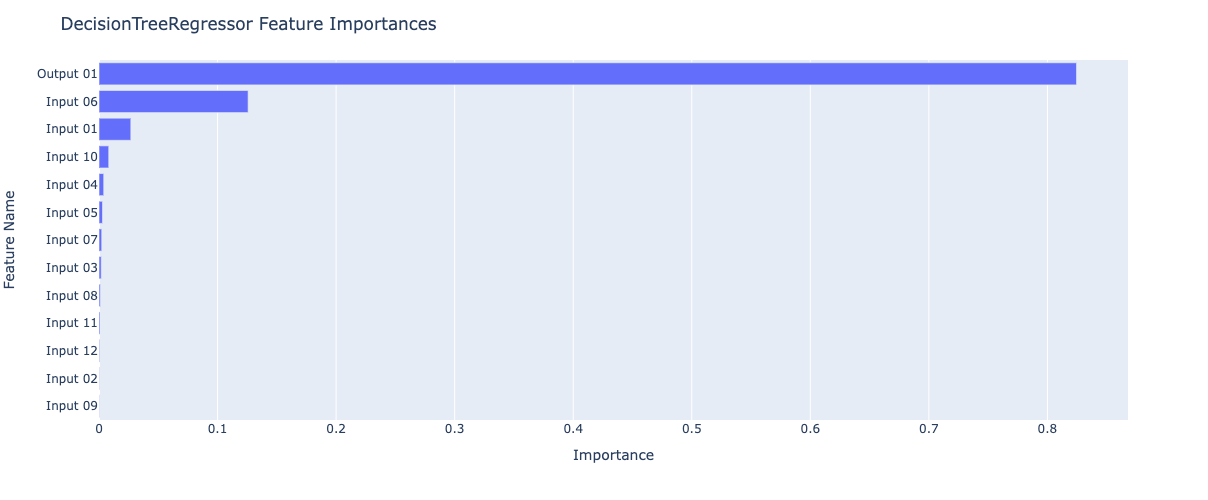

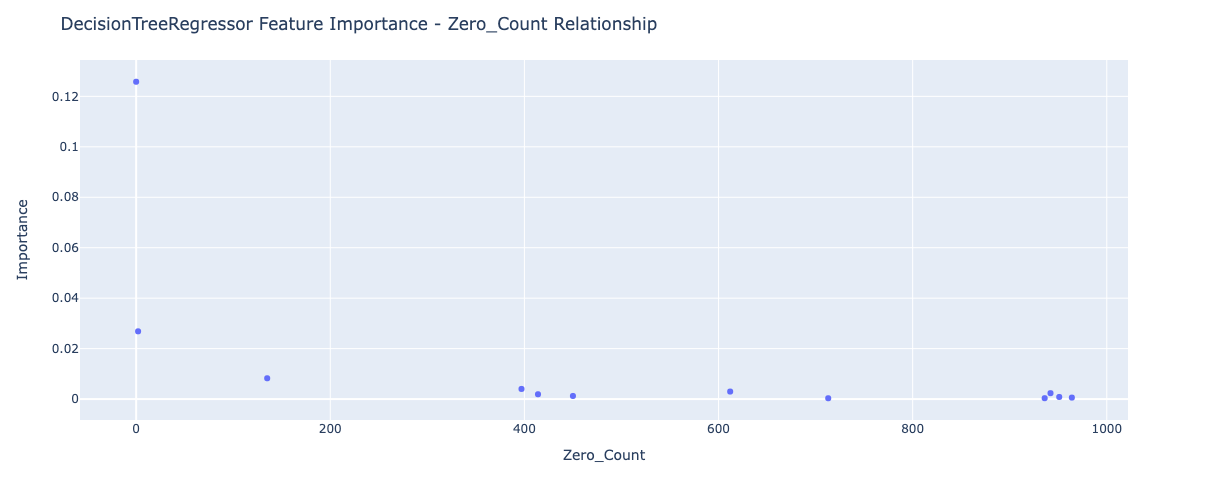

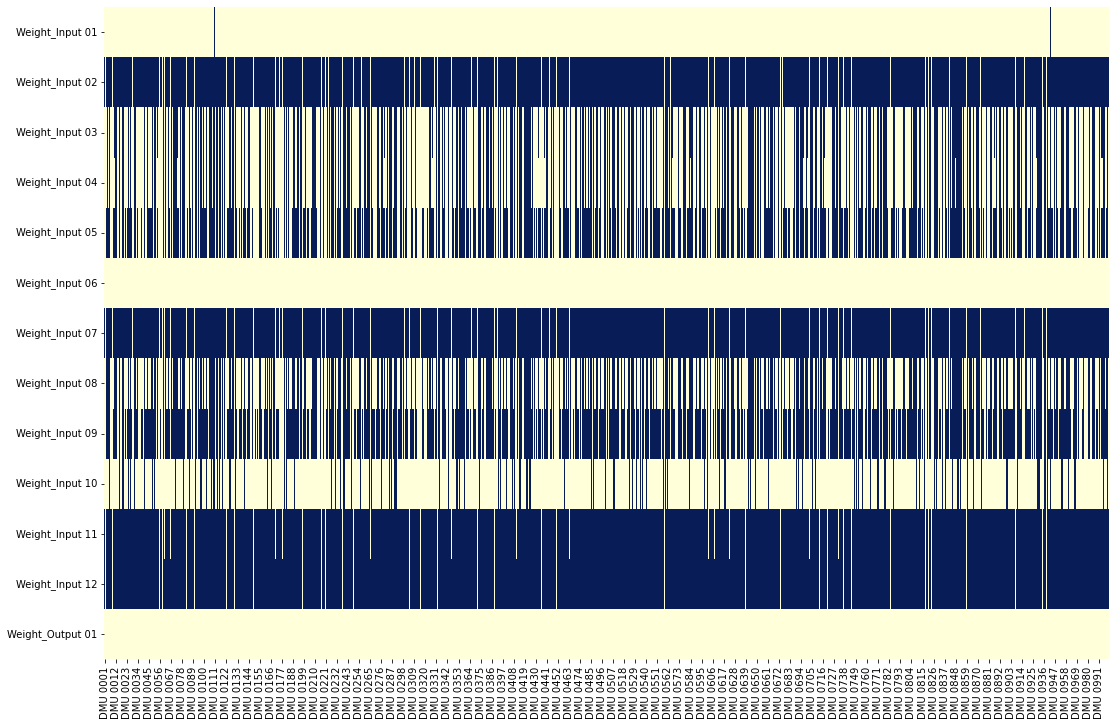

In [68]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_9.xlsx", i=i)
results.append(r)

In [69]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.807431  Output 01           0          0
1       Input 08    0.036786   Input 08         428          0
2       Input 01    0.030032   Input 01         330          0
3       Input 09    0.028091   Input 09         599          0
4       Input 03    0.025816   Input 03         249          0
..           ...         ...        ...         ...        ...
125     Input 08    0.001226   Input 08         450          9
126     Input 11    0.000830   Input 11         951          9
127     Input 12    0.000581   Input 12         964          9
128     Input 02    0.000346   Input 02         936          9
129     Input 09    0.000323   Input 09         713          9

[130 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6372  0.6588 -0.0217     -3.2872           False
1        0.6595  0.6134  0.0461      7.5233           False
2        0.7590  0.7733 -0.0143     -1.8464            True
3        0.8510  0.7917  0.0592      7.4832           False
4        0.7010  0.6831  0.0179      2.6215            True
..          ...     ...     ...         ...             ...
195      0.6728  0.7344 -0.0616     -8.3842           False
196      0.8302  0.7818  0.0484      6.1895           False
197      0.7060  0.7619 -0.0559     -7.3383           False
198      0.7558  0.7446  0.0112      1.5094            True
199      0.7845  0.7589  0.0256      3.3685           False

[200 rows x 5 columns]
blue:  68
red:  132
rho: 0.9018
p-Value 0.0


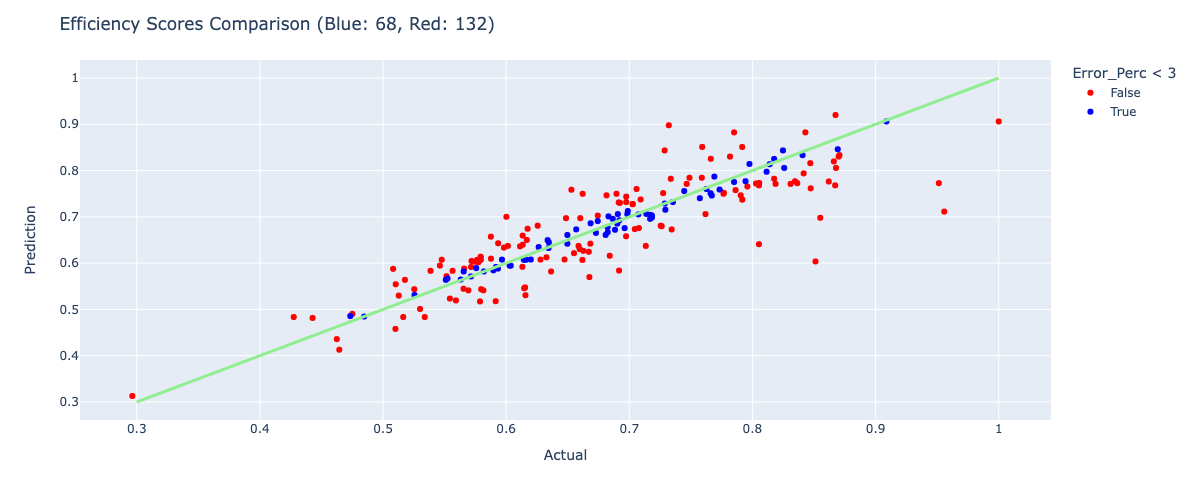

In [70]:
compareML(pipe_dt, y)

blue :  219
red :  781


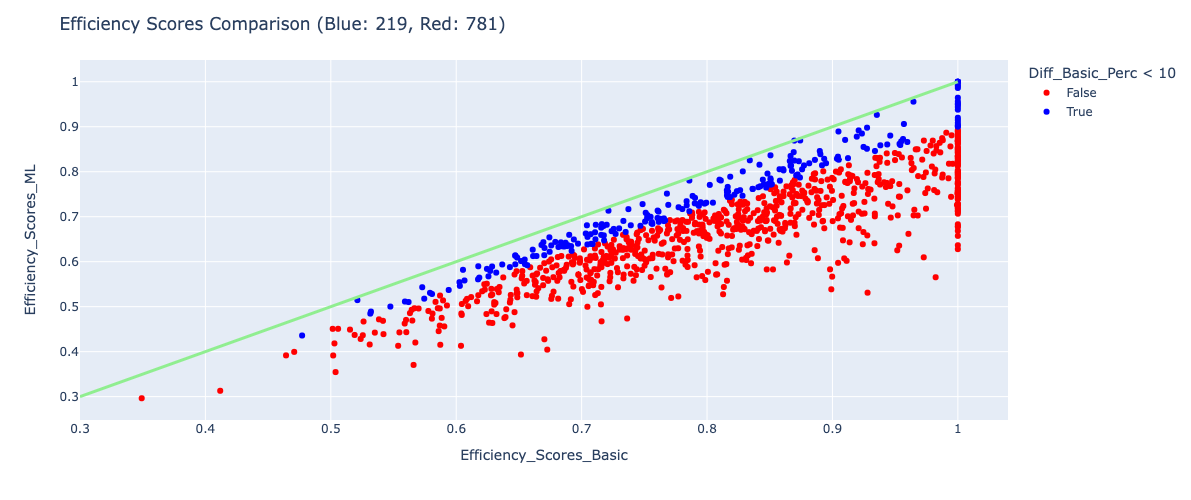

blue :  963
red :  37


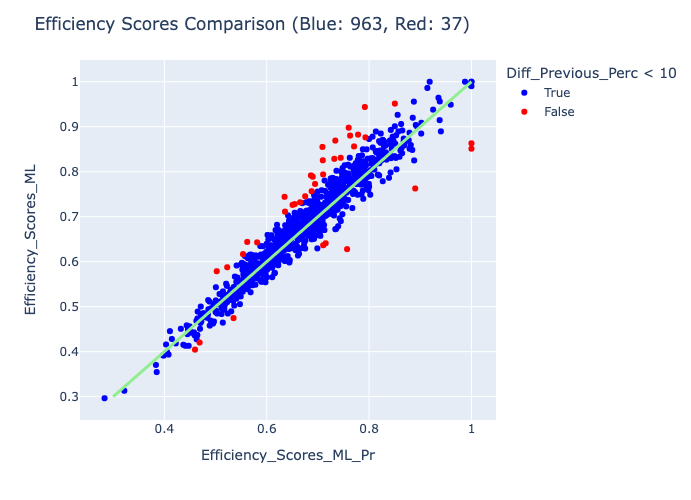

In [71]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_9.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_8.xlsx")

### i = 10

In [72]:
i +=1
i

10

In [73]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O.xlsx", folder = "Data/Data12/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01       2
Weight_Input 02     966
Weight_Input 03     487
Weight_Input 04     397
Weight_Input 05     433
Weight_Input 06       0
Weight_Input 07     434
Weight_Input 08     632
Weight_Input 09     975
Weight_Input 10     137
Weight_Input 11     782
Weight_Input 12     911
Weight_Output 01      0
dtype: int64
Total Zeros:  6156
neg_mean_squared_error: -0.0024500303532644903
neg_root_mean_squared_error: -0.04933614810420151
r2: 0.8216425055218759
grid.best_score:  -0.04686347098156769
grid.best_params:  {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 20}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=10, max_features='auto',
                                       min_samples_split=20,
                                       random_state=42))])
grid.r2:  0.8386339

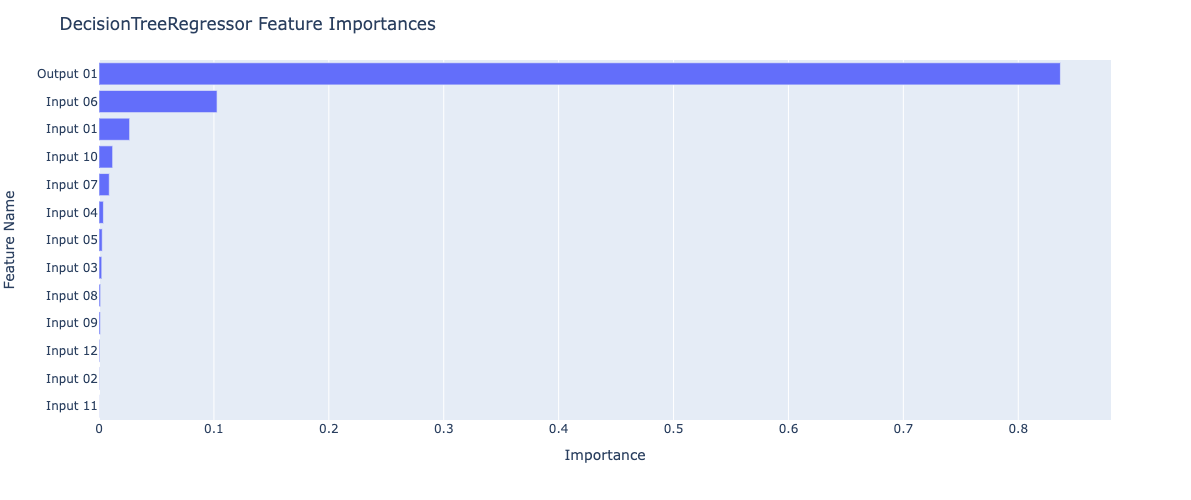

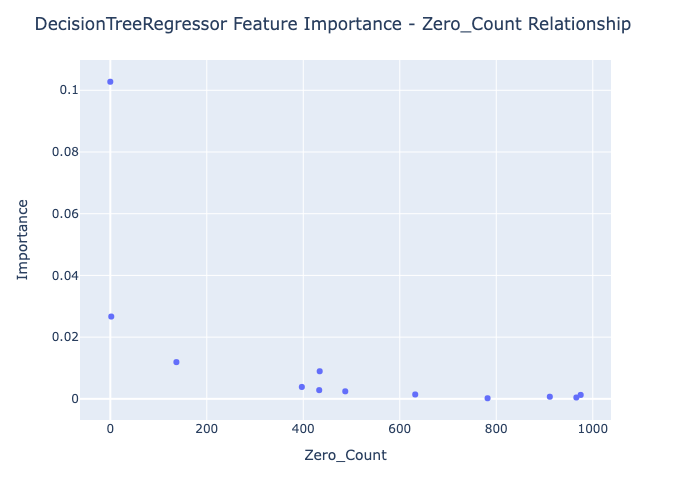

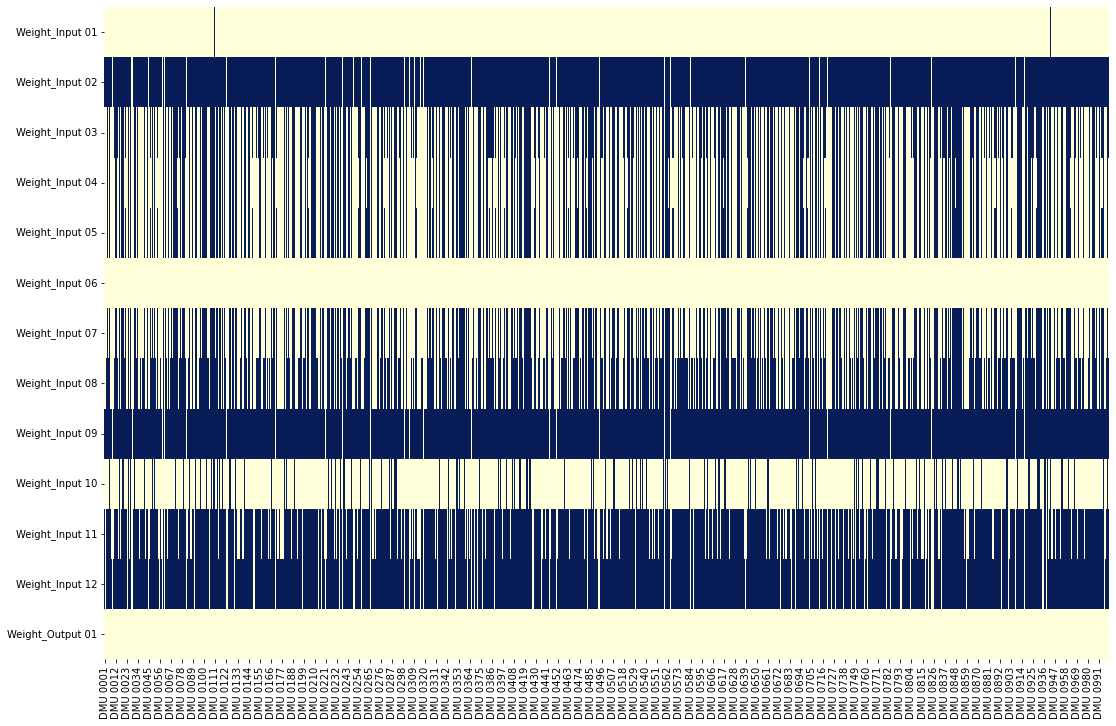

In [74]:
pipe_dt, r, y, df_merged = ml(sol_filepath="Data/Data12/US12I1O_decisiontreeregressor_Sol_10.xlsx", i=i)
results.append(r)

In [75]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.807431  Output 01           0          0
1       Input 08    0.036786   Input 08         428          0
2       Input 01    0.030032   Input 01         330          0
3       Input 09    0.028091   Input 09         599          0
4       Input 03    0.025816   Input 03         249          0
..           ...         ...        ...         ...        ...
138     Input 08    0.001412   Input 08         632         10
139     Input 09    0.001270   Input 09         975         10
140     Input 12    0.000678   Input 12         911         10
141     Input 02    0.000429   Input 02         966         10
142     Input 11    0.000187   Input 11         782         10

[143 rows x 5 columns]

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.6372  0.6588 -0.0217     -3.2872           False
1        0.6199  0.6009  0.0190      3.1676           False
2        0.7796  0.8053 -0.0258     -3.2007           False
3        0.7919  0.7859  0.0060      0.7649            True
4        0.7190  0.6831  0.0358      5.2472           False
..          ...     ...     ...         ...             ...
195      0.6998  0.7344 -0.0346     -4.7121           False
196      0.8349  0.7839  0.0510      6.5029           False
197      0.7136  0.7619 -0.0484     -6.3498           False
198      0.6755  0.7369 -0.0614     -8.3375           False
199      0.7304  0.7589 -0.0285     -3.7565           False

[200 rows x 5 columns]
blue:  71
red:  129
rho: 0.8937
p-Value 0.0


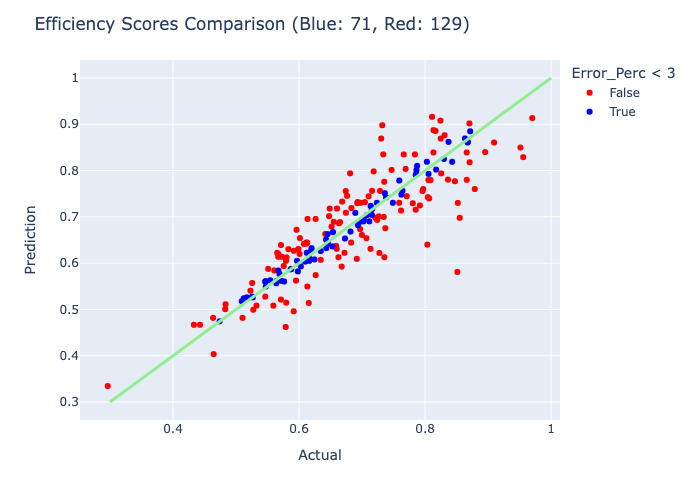

In [76]:
compareML(pipe_dt, y)

blue :  514
red :  486


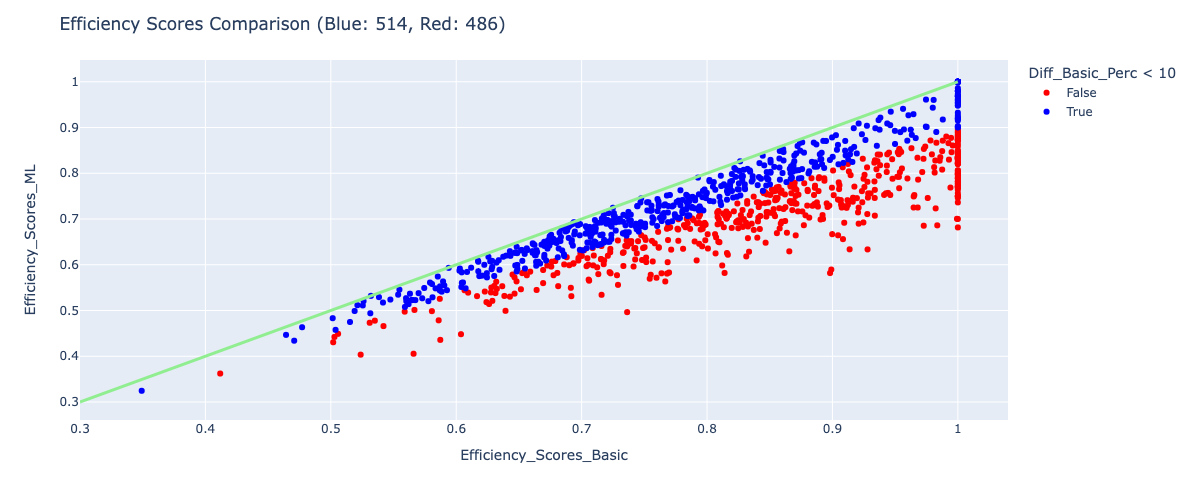

blue :  979
red :  21


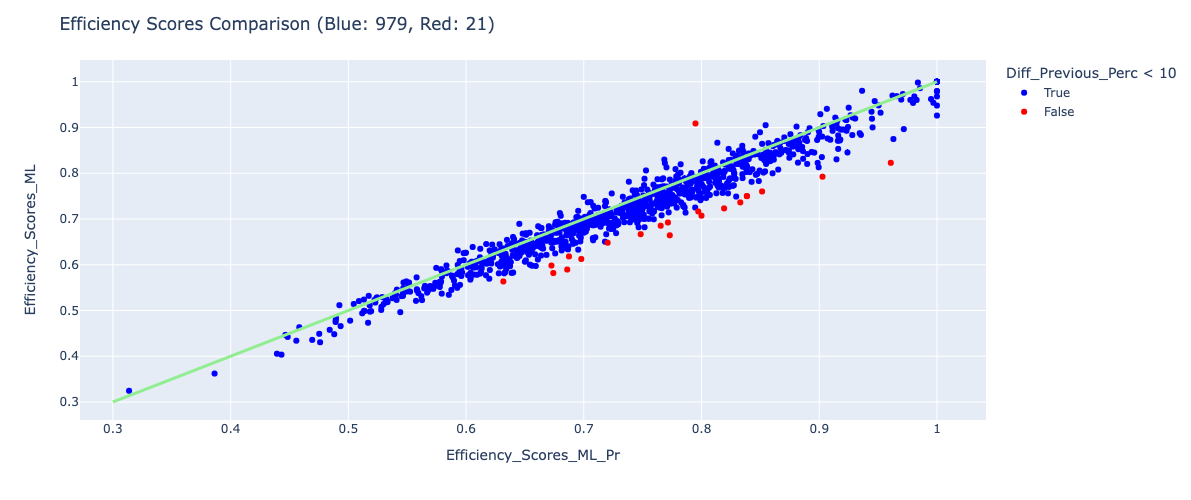

In [77]:
compareES(df_1_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_2.xlsx", df_0_path="Data/Data12/US12I1O_decisiontreeregressor_Sol_1.xlsx")

In [78]:
results

[(0,
  'decisiontreeregressor',
  ['Input 08',
   'Input 01',
   'Input 09',
   'Input 03',
   'Input 07',
   'Input 06',
   'Input 04',
   'Input 11',
   'Input 02',
   'Input 05',
   'Input 10',
   'Input 12'],
  {'r2': 0.7396661719274343,
   'neg_root_mean_squared_error': -0.06419162390336428,
   'total_zeros': 7203}),
 (1,
  'decisiontreeregressor',
  ['Input 08',
   'Input 01',
   'Input 06',
   'Input 03',
   'Input 12',
   'Input 10',
   'Input 11',
   'Input 07',
   'Input 02',
   'Input 04',
   'Input 05',
   'Input 09'],
  {'r2': 0.803206817996785,
   'neg_root_mean_squared_error': -0.04942233539912765,
   'total_zeros': 4154}),
 (2,
  'decisiontreeregressor',
  ['Input 08',
   'Input 01',
   'Input 06',
   'Input 12',
   'Input 05',
   'Input 09',
   'Input 03',
   'Input 11',
   'Input 02',
   'Input 10',
   'Input 04',
   'Input 07'],
  {'r2': 0.7842951766100591,
   'neg_root_mean_squared_error': -0.05167930620115213,
   'total_zeros': 4031}),
 (3,
  'decisiontreeregressor

In [79]:
with open('Data/Data12/DT_result_12I1O.pkl', 'wb') as f:
    pickle.dump(results, f)

In [80]:
with open('Data/Data12/DT_result_12I1O.pkl', 'rb') as f:
    r = pickle.load(f)

In [81]:
r

[(0,
  'decisiontreeregressor',
  ['Input 08',
   'Input 01',
   'Input 09',
   'Input 03',
   'Input 07',
   'Input 06',
   'Input 04',
   'Input 11',
   'Input 02',
   'Input 05',
   'Input 10',
   'Input 12'],
  {'r2': 0.7396661719274343,
   'neg_root_mean_squared_error': -0.06419162390336428,
   'total_zeros': 7203}),
 (1,
  'decisiontreeregressor',
  ['Input 08',
   'Input 01',
   'Input 06',
   'Input 03',
   'Input 12',
   'Input 10',
   'Input 11',
   'Input 07',
   'Input 02',
   'Input 04',
   'Input 05',
   'Input 09'],
  {'r2': 0.803206817996785,
   'neg_root_mean_squared_error': -0.04942233539912765,
   'total_zeros': 4154}),
 (2,
  'decisiontreeregressor',
  ['Input 08',
   'Input 01',
   'Input 06',
   'Input 12',
   'Input 05',
   'Input 09',
   'Input 03',
   'Input 11',
   'Input 02',
   'Input 10',
   'Input 04',
   'Input 07'],
  {'r2': 0.7842951766100591,
   'neg_root_mean_squared_error': -0.05167930620115213,
   'total_zeros': 4031}),
 (3,
  'decisiontreeregressor

In [82]:
df_imp

Feature Name  Importance      index  Zero_Count  Iteration
0      Output 01    0.807431  Output 01           0          0
1       Input 08    0.036786   Input 08         428          0
2       Input 01    0.030032   Input 01         330          0
3       Input 09    0.028091   Input 09         599          0
4       Input 03    0.025816   Input 03         249          0
..           ...         ...        ...         ...        ...
138     Input 08    0.001412   Input 08         632         10
139     Input 09    0.001270   Input 09         975         10
140     Input 12    0.000678   Input 12         911         10
141     Input 02    0.000429   Input 02         966         10
142     Input 11    0.000187   Input 11         782         10

[143 rows x 5 columns]

In [83]:
df_imp.Iteration.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [86]:
df_imp.to_pickle('Data/Data12/DT_12I1O_df_imp.pkl')